In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

import os
import time
import math
import numpy as np
import skimage.io as io
from torchsummary import summary

from di_dataset2 import DepthImageDataset, collate_batch

2022-03-01 20:59:49.009912: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Hyperparams

In [4]:
latent_dim = 64
num_epochs = 10
batch_size = 32
learning_rate = 1e-3

save_model = True
load_model = False

save_model_file = "../../../vae_models/vae_resnet_drone_net_mse.pth"
load_model_file = "../../../vae_models/vae_resnet_drone_net_nopool.pth"

# Load Dataset

In [5]:
tfrecord_folder='../../../rl_data/tfrecord'
tfrecord_test_folder='../../../rl_data/tfrecord/test'

In [6]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size) # 176 tfrecords
test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size) # 20 tfrecords

Loading tfrecords...
['../../../rl_data/tfrecord/data74.tfrecords']
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-03-01 20:59:50.266458: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-01 20:59:50.267978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-01 20:59:50.273771: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-01 20:59:50.273790: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (patricknit-OptiPlex-7060): /proc/driver/nvidia/version does not exist
2022-03-01 20:59:50.274212: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate co

Iterating length...
Done.
Loading tfrecords...
['../../../rl_data/tfrecord/test/data186.tfrecords']
Iterating length...
Done.


In [7]:
len_train_dataset = len(train_dataset)
len_test_dataset = len(test_dataset)
n_training_samples = len_train_dataset * 32 # 32 samples per batch
print(len_train_dataset, len_test_dataset)
n_training_samples

73 78


2336

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)

In [9]:
dataiter = iter(train_loader)
image_batch, *_ = dataiter.next() # image, height, width, depth
image_batch.shape

GOTCHA


torch.Size([32, 1, 270, 480])

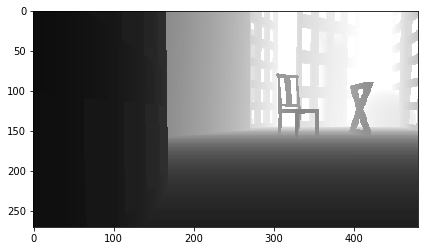

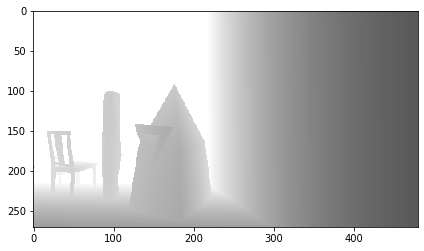

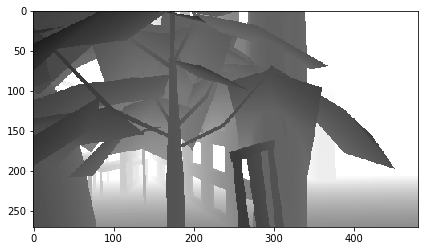

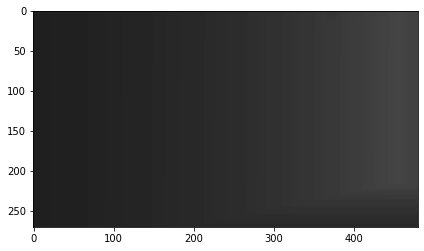

torch.Size([1, 270, 480])

In [10]:
def imshow(image):
    io.imshow(image.squeeze().numpy())
    io.show()

for image in image_batch[0:4]:
    imshow(image)
    
image.shape

In [11]:
image_batch.squeeze().mean(), image_batch.squeeze().var()

(tensor(0.4858), tensor(0.1255))

# Define Variational Autoencoder

Adapted from https://github.com/microsoft/AirSim-Drone-Racing-VAE-Imitation/blob/master/racing_models/cmvae.py

### Dronet
ResNet8 as encoder.

In [12]:
image_batch, *_ = dataiter.next()

In [13]:
class Dronet(nn.Module):
    def __init__(self, input_dim, num_outputs, include_top=True):
        super(Dronet, self).__init__()
        self.include_top = include_top
        
        print('[Dronet] Starting dronet')

        self.max0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # default pool_size='2', strides=2

        self.bn0 = nn.BatchNorm2d(32)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)

        self.conv0 = nn.Conv2d(input_dim, 32, kernel_size=5, stride=2, padding=2)
        self.xavier_uniform_init(self.conv0)
        
        self.conv0_2 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2)

        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1) # padding='same' 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=1, stride=2)
        self.xavier_uniform_init(self.conv3)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv6 = nn.Conv2d(32, 64, kernel_size=1, stride=2) # padding='same'
        self.xavier_uniform_init(self.conv6)

        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # padding='same' # Todo: kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        self.conv9 = nn.Conv2d(64, 128, kernel_size=1, stride=2) # padding='same'
        self.xavier_uniform_init(self.conv9)

        self.dense0 = nn.Linear(9*15*128, 64) # Todo: check size
        self.dense1 = nn.Linear(64, 32)
        self.dense2 = nn.Linear(32, num_outputs)
        self.dense3 = nn.Linear(9*15*128, num_outputs)

        print('[Dronet] Done with dronet')
    
    
    def xavier_uniform_init(self, m):
        """
        Default initialisation in Keras is glorot_uniform == xavier_uniform in Pytorch

        https://discuss.pytorch.org/t/crossentropyloss-expected-object-of-type-torch-longtensor/28683/6?u=ptrblck
        https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        """
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('linear')) # gain=nn.init.calculate_gain('relu')
            nn.init.zeros_(m.bias)
        return m

    def forward(self, img):
        # Input
        
        #print(img.shape)
        #print(f"- Before encoding, mean: {img.mean():.3f} var: {img.var():.3f}")
        x1 = self.conv0(img)
        #print("x1:", x1.shape)
        #x1, indices = self.max0(x1)
        x1 = self.conv0_2(x1)
        #print("x1:", x1.shape)

        # First residual block
        x2 = self.bn0(x1)
        #print("x2:", x2.shape)
        # x2 = x1
        x2 = torch.relu(x2)
        #print(x2.shape)
        x2 = self.conv1(x2)
        #print(x2.shape)

        x2 = self.bn1(x2)
        #print(x2.shape)
        x2 = torch.relu(x2)
        #print(x2.shape)
        x2 = self.conv2(x2)
        #print(x2.shape)
        
        
        x1 = self.conv3(x1)
        #print(f"x1: {x1.shape}, x2: {x2.shape}") # 32, 34, 60
        x3 = x1+x2
        #print("x3:", x3.shape)

        # Second residual block
        x4 = self.bn2(x3)
        #print("x4:", x4.shape)
        # x4 = x3
        x4 = torch.relu(x4)
        x4 = self.conv4(x4)
        #print(x4.shape)

        x4 = self.bn3(x4)
        #print(x4.shape)
        x4 = torch.relu(x4)
        x4 = self.conv5(x4)
        #print(x4.shape)
        
        x3 = self.conv6(x3)
        #print(f"x3: {x3.shape}, x4: {x4.shape}")
        x5 = x3+x4 # 34, 60, 64

        # Third residual block
        x6 = self.bn4(x5)
        # x6 = x5
        x6 = torch.relu(x6)
        x6 = self.conv7(x6)

        x6 = self.bn5(x6)
        x6 = torch.relu(x6)
        x6 = self.conv8(x6)

        x5 = self.conv9(x5)
        #print(f"x5: {x5.shape}, x6: {x6.shape}")
        x7 = x5+x6 # 17, 30, 128

        x = x7.view(x7.size(0), -1)
        #print(f"x before linear: {x.shape}")
        #print(f"- After encoding, mean: {x.mean():.3f} var: {x.var():.3f}")

        if self.include_top:
            x = torch.relu(x)
            # x = tf.keras.layers.Dropout(0.5)(x)
            x = self.dense0(x)
            x = self.dense1(x)
            #gate_pose = self.dense2(x)
            x_enc = self.dense2(x)
            # phi_rel = self.dense_phi_rel(x)
            # gate_pose = tf.concat([gate_pose, phi_rel], 1)
            #print(f"x_enc: {x.shape}")
            return x_enc
        else:
            x = self.dense3(x)
            #print(f"x_enc: {x.shape}")
            return x

dronet = Dronet(input_dim=1, num_outputs=latent_dim*2, include_top=True)
summary(dronet, input_size=(1, 270, 480), batch_size=-1, device=device.type)

[Dronet] Starting dronet
[Dronet] Done with dronet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]             128
           Conv2d-11           [-1, 64, 17, 30]          36,928
           Conv2d-12           [-1, 64, 17, 30]           2,112
      BatchNorm2d-13           [-1, 64, 17, 30]     

### Decoder

In [14]:
class ImgDecoder(nn.Module):
    def __init__(self, input_dim=100, batch=32):
        super(ImgDecoder, self).__init__()
        print('[ImgDecoder] Starting create_model')
        self.dense = nn.Linear(input_dim, 9*15*128)
        
        self.bn0 = nn.BatchNorm2d(128)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv3 = nn.ConvTranspose2d(64, 64, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv5 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv6 = nn.ConvTranspose2d(32, 16, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0))
        self.deconv7 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=1, padding=2) # tanh activation or sigmoid

        print('[ImgDecoder] Done with create_model')

    def forward(self, z):
        #print("z: ", z.shape)
        x = self.dense(z)
        #print(x.shape)
        x = x.view(x.size(0), 128, 9, 15)
        #print(f"- Before deconv, mean: {x.mean():.3f} var: {x.var():.3f}")
        x = self.deconv1(x)
        x = torch.relu(x)
        #print("after deconv1", x.shape)
        x = self.deconv2(x)
        x = torch.relu(x)
        #print("after deconv2", x.shape)
        x = self.deconv3(x)
        x = torch.relu(x)
#         print("after deconv3", x.shape)
        x = self.deconv4(x)
        x = torch.relu(x)
#         print("after deconv4", x.shape)
        x = self.deconv5(x)
        #print("indices", indices.shape)
        #x = self.unpool(x, indices, output_size=(x.size(0), 1, 135, 240))
#         print("after deconv5", x.shape)
        x = torch.relu(x)
        #print("after unpool", x.shape)
        x = self.deconv6(x)
        x = torch.relu(x)
#         print("after deconv6", x.shape)
        x = self.deconv7(x)
        print(f"- After deconv 7, mean: {x.mean():.3f} var: {x.var():.3f}")
        x = torch.sigmoid(x)
        print(f"- After sigmoid, mean: {x.mean():.3f} var: {x.var():.3f}")
        #print("after deconv7", x.shape)
        return x

img_decoder = ImgDecoder(input_dim=latent_dim, batch=1)
summary(img_decoder, (1,latent_dim))

[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model
- After deconv 7, mean: -0.170 var: 0.000
- After sigmoid, mean: 0.458 var: 0.000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 17280]       1,123,200
   ConvTranspose2d-2           [-1, 128, 9, 15]         147,584
   ConvTranspose2d-3           [-1, 64, 17, 30]         204,864
   ConvTranspose2d-4           [-1, 64, 34, 60]         147,520
   ConvTranspose2d-5          [-1, 32, 68, 120]          73,760
   ConvTranspose2d-6         [-1, 32, 135, 240]          25,632
   ConvTranspose2d-7         [-1, 16, 270, 480]          18,448
   ConvTranspose2d-8          [-1, 1, 270, 480]             401
Total params: 1,741,409
Trainable params: 1,741,409
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 28.22
Para

## VAE

In [15]:
class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
        

class VAE(nn.Module):
    def __init__(self, n_z):
        super(VAE, self).__init__()
        
        # create the 3 base models:
        self.q_img = Dronet(input_dim=1, num_outputs=latent_dim*2, include_top=True)
        self.p_img = ImgDecoder(input_dim=n_z)
        
        # Create sampler
        self.mean_params = Lambda(lambda x: x[:, :n_z])
        self.logvar_params = Lambda(lambda x: x[:, n_z:])

    def forward(self, x):
        # Possible modes for reconstruction:
        # img -> img

        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.randn_like(stddev)
        z = means + eps * stddev
        #print(z.shape)
        #print("OK")
        img_recon = self.p_img(z)
        return img_recon, means, logvar, z
    
    def forward_test(self, x):
        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.zeros_like(stddev)
        z = means + eps * stddev
        #print(z.shape)
        #print("OK")
        img_recon = self.p_img(z)
        return img_recon, means, logvar, z
        

    def encode(self, x):
        x = self.q_img(x)
        means = self.mean_params(x)
        stddev = torch.exp(0.5 * self.stddev_params(x))
        eps = torch.randn_like(stddev)
        z = means + eps * stddev
        return z, means, stddev

    def decode(self, z, mode):
        # Possible modes for reconstruction:
        # z -> img
        img_recon = self.p_img(z)
        return img_recon


### Define Model

In [27]:
vae_model = VAE(n_z=latent_dim)

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
    vae_model.eval()
else:
    vae_model.train()

optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
summary(vae_model, (1, 270, 480))

[Dronet] Starting dronet
[Dronet] Done with dronet
[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model
- After deconv 7, mean: 0.008 var: 0.000
- After sigmoid, mean: 0.502 var: 0.000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]             128
           Conv2d-11        

# Training

In [28]:
def BCELoss(x, x_hat, mean, log_var):
    reproduction_loss = nn.BCELoss(reduction='sum')(x_hat, x)
    KLD      = 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss - KLD

def mse_loss(x, x_hat, mu, logvar):
    reproduction_loss = F.mse_loss(x_hat, x, reduction="sum")
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss - kl_divergence

Loading tfrecords...
['../../../rl_data/tfrecord/data56.tfrecords']
Iterating length...
Done.
GOTCHA
- After deconv 7, mean: 0.008 var: 0.000
- After sigmoid, mean: 0.502 var: 0.000
Epoch: 1/10, Step: 1/65, Avg loss: 12277.459, time: 5.15, Avg. per iter 4.62, Est. time left 295.62

- After deconv 7, mean: -0.006 var: 0.000
- After sigmoid, mean: 0.499 var: 0.000
Epoch: 1/10, Step: 2/65, Avg loss: 13734.732, time: 9.64, Avg. per iter 4.56, Est. time left 287.06

- After deconv 7, mean: -0.005 var: 0.000
- After sigmoid, mean: 0.499 var: 0.000
Epoch: 1/10, Step: 3/65, Avg loss: 14152.536, time: 13.92, Avg. per iter 4.46, Est. time left 276.71

- After deconv 7, mean: 0.003 var: 0.000
- After sigmoid, mean: 0.501 var: 0.000
Epoch: 1/10, Step: 4/65, Avg loss: 14408.793, time: 18.05, Avg. per iter 4.38, Est. time left 267.10

- After deconv 7, mean: 0.004 var: 0.000
- After sigmoid, mean: 0.501 var: 0.000
Epoch: 1/10, Step: 5/65, Avg loss: 14546.979, time: 22.36, Avg. per iter 4.37, Est. ti

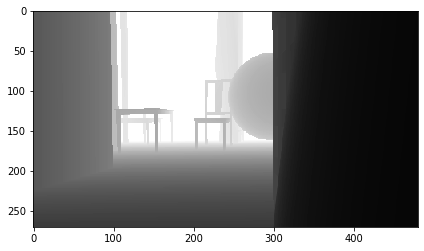

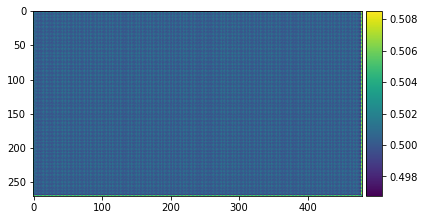

- After deconv 7, mean: -0.004 var: 0.000
- After sigmoid, mean: 0.499 var: 0.000
Epoch: 1/10, Step: 11/65, Avg loss: 14381.360, time: 49.57, Avg. per iter 4.43, Est. time left 239.31

- After deconv 7, mean: -0.008 var: 0.000
- After sigmoid, mean: 0.498 var: 0.000
Epoch: 1/10, Step: 12/65, Avg loss: 14332.729, time: 53.96, Avg. per iter 4.43, Est. time left 234.68

- After deconv 7, mean: -0.011 var: 0.000
- After sigmoid, mean: 0.497 var: 0.000
Epoch: 1/10, Step: 13/65, Avg loss: 14403.791, time: 58.48, Avg. per iter 4.43, Est. time left 230.60

- After deconv 7, mean: -0.015 var: 0.000
- After sigmoid, mean: 0.496 var: 0.000
Epoch: 1/10, Step: 14/65, Avg loss: 14300.547, time: 62.82, Avg. per iter 4.43, Est. time left 225.82

- After deconv 7, mean: -0.019 var: 0.000
- After sigmoid, mean: 0.495 var: 0.000
Epoch: 1/10, Step: 15/65, Avg loss: 14292.172, time: 67.24, Avg. per iter 4.43, Est. time left 221.34

- After deconv 7, mean: -0.023 var: 0.000
- After sigmoid, mean: 0.494 var:

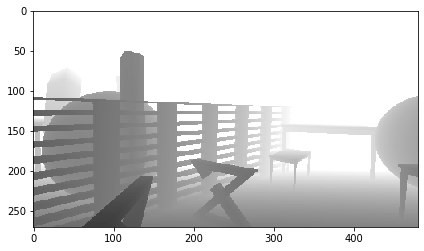

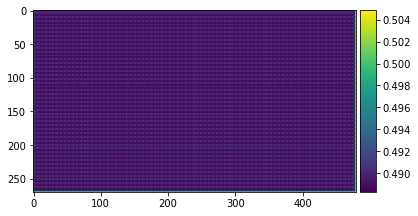

- After deconv 7, mean: -0.044 var: 0.000
- After sigmoid, mean: 0.489 var: 0.000
Epoch: 1/10, Step: 21/65, Avg loss: 14604.139, time: 93.37, Avg. per iter 4.39, Est. time left 193.38

- After deconv 7, mean: -0.043 var: 0.000
- After sigmoid, mean: 0.489 var: 0.000
Epoch: 1/10, Step: 22/65, Avg loss: 14555.212, time: 97.95, Avg. per iter 4.40, Est. time left 189.35

- After deconv 7, mean: -0.041 var: 0.000
- After sigmoid, mean: 0.490 var: 0.000
Epoch: 1/10, Step: 23/65, Avg loss: 14476.313, time: 102.51, Avg. per iter 4.41, Est. time left 185.22

- After deconv 7, mean: -0.039 var: 0.000
- After sigmoid, mean: 0.490 var: 0.000
Epoch: 1/10, Step: 24/65, Avg loss: 14519.273, time: 106.87, Avg. per iter 4.41, Est. time left 180.72

- After deconv 7, mean: -0.037 var: 0.000
- After sigmoid, mean: 0.491 var: 0.000
Epoch: 1/10, Step: 25/65, Avg loss: 14514.758, time: 111.30, Avg. per iter 4.41, Est. time left 176.35

- After deconv 7, mean: -0.035 var: 0.000
- After sigmoid, mean: 0.491 v

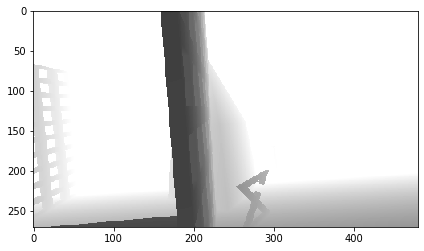

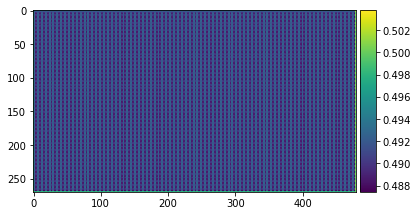

- After deconv 7, mean: -0.038 var: 0.000
- After sigmoid, mean: 0.491 var: 0.000
Epoch: 1/10, Step: 31/65, Avg loss: 14252.904, time: 138.64, Avg. per iter 4.42, Est. time left 150.43

- After deconv 7, mean: -0.040 var: 0.000
- After sigmoid, mean: 0.490 var: 0.000
Epoch: 1/10, Step: 32/65, Avg loss: 14244.224, time: 142.97, Avg. per iter 4.42, Est. time left 145.91

- After deconv 7, mean: -0.041 var: 0.000
- After sigmoid, mean: 0.490 var: 0.000
Epoch: 1/10, Step: 33/65, Avg loss: 14280.329, time: 147.76, Avg. per iter 4.43, Est. time left 141.84

- After deconv 7, mean: -0.043 var: 0.000
- After sigmoid, mean: 0.489 var: 0.000
Epoch: 1/10, Step: 34/65, Avg loss: 14290.862, time: 152.91, Avg. per iter 4.45, Est. time left 138.06

- After deconv 7, mean: -0.046 var: 0.000
- After sigmoid, mean: 0.489 var: 0.000
Epoch: 1/10, Step: 35/65, Avg loss: 14347.487, time: 158.10, Avg. per iter 4.47, Est. time left 134.24

- After deconv 7, mean: -0.049 var: 0.000
- After sigmoid, mean: 0.488

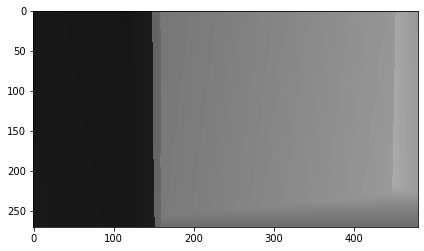

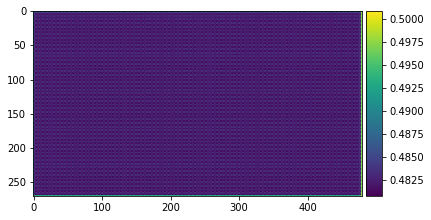

- After deconv 7, mean: -0.072 var: 0.000
- After sigmoid, mean: 0.482 var: 0.000
Epoch: 1/10, Step: 41/65, Avg loss: 14479.051, time: 185.48, Avg. per iter 4.48, Est. time left 107.56

- After deconv 7, mean: -0.073 var: 0.000
- After sigmoid, mean: 0.482 var: 0.000
Epoch: 1/10, Step: 42/65, Avg loss: 14439.676, time: 190.57, Avg. per iter 4.50, Est. time left 103.41

- After deconv 7, mean: -0.075 var: 0.000
- After sigmoid, mean: 0.481 var: 0.000
Epoch: 1/10, Step: 43/65, Avg loss: 14421.643, time: 195.19, Avg. per iter 4.50, Est. time left 98.98

- After deconv 7, mean: -0.078 var: 0.000
- After sigmoid, mean: 0.480 var: 0.000
Epoch: 1/10, Step: 44/65, Avg loss: 14437.124, time: 199.50, Avg. per iter 4.49, Est. time left 94.39

- After deconv 7, mean: -0.080 var: 0.000
- After sigmoid, mean: 0.480 var: 0.000
Epoch: 1/10, Step: 45/65, Avg loss: 14501.349, time: 203.97, Avg. per iter 4.49, Est. time left 89.88

- After deconv 7, mean: -0.080 var: 0.000
- After sigmoid, mean: 0.480 va

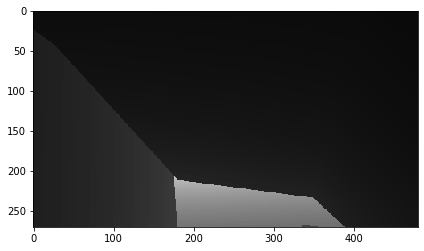

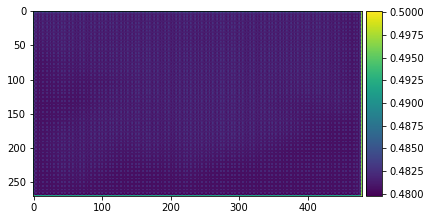

- After deconv 7, mean: -0.070 var: 0.000
- After sigmoid, mean: 0.482 var: 0.000
Epoch: 1/10, Step: 51/65, Avg loss: 14468.535, time: 231.30, Avg. per iter 4.50, Est. time left 62.94

- After deconv 7, mean: -0.069 var: 0.000
- After sigmoid, mean: 0.483 var: 0.000
Epoch: 1/10, Step: 52/65, Avg loss: 14487.172, time: 235.82, Avg. per iter 4.50, Est. time left 58.46

- After deconv 7, mean: -0.069 var: 0.000
- After sigmoid, mean: 0.483 var: 0.000
Epoch: 1/10, Step: 53/65, Avg loss: 14494.220, time: 240.31, Avg. per iter 4.50, Est. time left 53.96

- After deconv 7, mean: -0.068 var: 0.000
- After sigmoid, mean: 0.483 var: 0.000
Epoch: 1/10, Step: 54/65, Avg loss: 14490.389, time: 245.06, Avg. per iter 4.50, Est. time left 49.51

- After deconv 7, mean: -0.068 var: 0.000
- After sigmoid, mean: 0.483 var: 0.000
Epoch: 1/10, Step: 55/65, Avg loss: 14486.131, time: 249.71, Avg. per iter 4.50, Est. time left 45.04

- After deconv 7, mean: -0.070 var: 0.000
- After sigmoid, mean: 0.483 var:

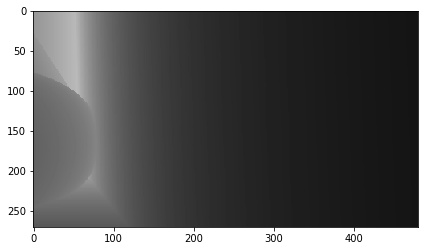

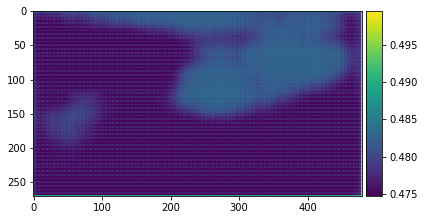

- After deconv 7, mean: -0.083 var: 0.000
- After sigmoid, mean: 0.479 var: 0.000
Epoch: 1/10, Step: 61/65, Avg loss: 14511.211, time: 277.75, Avg. per iter 4.52, Est. time left 18.06

- After deconv 7, mean: -0.084 var: 0.001
- After sigmoid, mean: 0.479 var: 0.000
Epoch: 1/10, Step: 62/65, Avg loss: 14509.370, time: 282.72, Avg. per iter 4.52, Est. time left 13.57

- After deconv 7, mean: -0.063 var: 0.002
- After sigmoid, mean: 0.484 var: 0.000
Epoch: 1/10, Step: 63/65, Avg loss: 14506.126, time: 287.56, Avg. per iter 4.53, Est. time left 9.06

- After deconv 7, mean: -0.017 var: 0.007
- After sigmoid, mean: 0.496 var: 0.000
Epoch: 1/10, Step: 64/65, Avg loss: 14484.103, time: 292.59, Avg. per iter 4.54, Est. time left 4.54

- After deconv 7, mean: 0.005 var: 0.017
- After sigmoid, mean: 0.501 var: 0.001
Epoch: 1/10, Step: 65/65, Avg loss: 14371.617, time: 295.02, Avg. per iter 4.50, Est. time left 0.00

Loading tfrecords...
['../../../rl_data/tfrecord/data145.tfrecords']
Iterating 

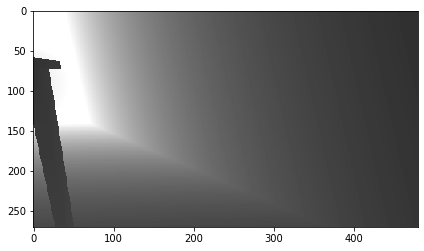

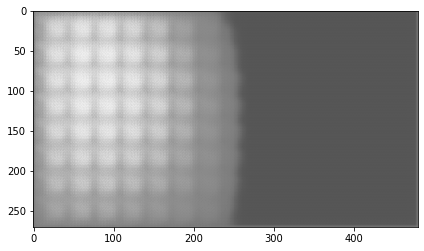

- After deconv 7, mean: 0.379 var: 1.842
- After sigmoid, mean: 0.547 var: 0.052
Epoch: 2/10, Step: 11/58, Avg loss: 11025.829, time: 48.41, Avg. per iter 4.48, Est. time left 210.55

- After deconv 7, mean: 0.166 var: 1.240
- After sigmoid, mean: 0.521 var: 0.050
Epoch: 2/10, Step: 12/58, Avg loss: 10831.616, time: 52.59, Avg. per iter 4.48, Est. time left 205.89

- After deconv 7, mean: -0.278 var: 0.885
- After sigmoid, mean: 0.433 var: 0.042
Epoch: 2/10, Step: 13/58, Avg loss: 10616.318, time: 56.90, Avg. per iter 4.47, Est. time left 201.32

- After deconv 7, mean: -0.341 var: 1.069
- After sigmoid, mean: 0.422 var: 0.050
Epoch: 2/10, Step: 14/58, Avg loss: 10479.064, time: 61.72, Avg. per iter 4.48, Est. time left 197.03

- After deconv 7, mean: -0.249 var: 1.521
- After sigmoid, mean: 0.436 var: 0.061
Epoch: 2/10, Step: 15/58, Avg loss: 10220.489, time: 66.88, Avg. per iter 4.49, Est. time left 192.92

- After deconv 7, mean: -0.071 var: 1.735
- After sigmoid, mean: 0.476 var: 0

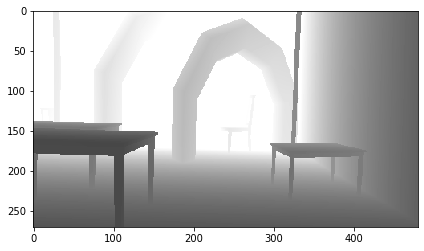

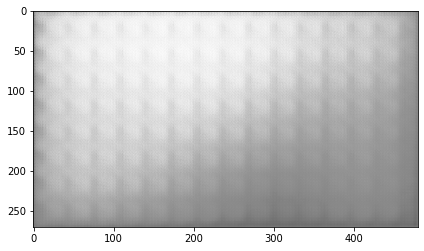

- After deconv 7, mean: 0.217 var: 2.279
- After sigmoid, mean: 0.530 var: 0.083
Epoch: 2/10, Step: 21/58, Avg loss: 9184.352, time: 94.61, Avg. per iter 4.49, Est. time left 166.27

- After deconv 7, mean: 0.193 var: 2.086
- After sigmoid, mean: 0.526 var: 0.076
Epoch: 2/10, Step: 22/58, Avg loss: 9105.649, time: 98.83, Avg. per iter 4.49, Est. time left 161.66

- After deconv 7, mean: 0.068 var: 1.951
- After sigmoid, mean: 0.501 var: 0.072
Epoch: 2/10, Step: 23/58, Avg loss: 8985.013, time: 103.08, Avg. per iter 4.49, Est. time left 157.07

- After deconv 7, mean: -0.186 var: 1.736
- After sigmoid, mean: 0.452 var: 0.068
Epoch: 2/10, Step: 24/58, Avg loss: 8874.447, time: 107.46, Avg. per iter 4.49, Est. time left 152.54

- After deconv 7, mean: -0.364 var: 1.116
- After sigmoid, mean: 0.424 var: 0.051
Epoch: 2/10, Step: 25/58, Avg loss: 8777.604, time: 112.29, Avg. per iter 4.49, Est. time left 148.18

- After deconv 7, mean: -0.578 var: 1.093
- After sigmoid, mean: 0.376 var: 0.04

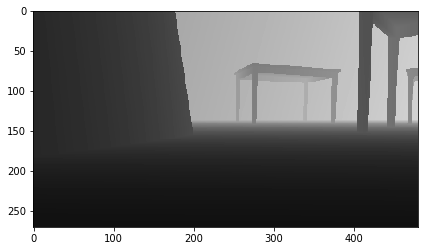

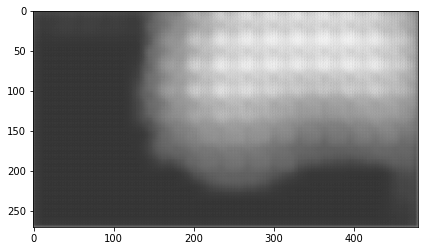

- After deconv 7, mean: 0.832 var: 5.293
- After sigmoid, mean: 0.564 var: 0.095
Epoch: 2/10, Step: 31/58, Avg loss: 8309.816, time: 142.26, Avg. per iter 4.52, Est. time left 122.03

- After deconv 7, mean: 0.787 var: 6.679
- After sigmoid, mean: 0.546 var: 0.090
Epoch: 2/10, Step: 32/58, Avg loss: 8294.510, time: 146.75, Avg. per iter 4.52, Est. time left 117.51

- After deconv 7, mean: 0.452 var: 3.952
- After sigmoid, mean: 0.523 var: 0.086
Epoch: 2/10, Step: 33/58, Avg loss: 8224.128, time: 151.28, Avg. per iter 4.52, Est. time left 112.99

- After deconv 7, mean: -0.032 var: 2.005
- After sigmoid, mean: 0.468 var: 0.067
Epoch: 2/10, Step: 34/58, Avg loss: 8175.483, time: 155.70, Avg. per iter 4.52, Est. time left 108.44

- After deconv 7, mean: -0.181 var: 0.972
- After sigmoid, mean: 0.457 var: 0.047
Epoch: 2/10, Step: 35/58, Avg loss: 8153.926, time: 160.07, Avg. per iter 4.52, Est. time left 103.89

- After deconv 7, mean: -0.273 var: 0.988
- After sigmoid, mean: 0.434 var: 0.

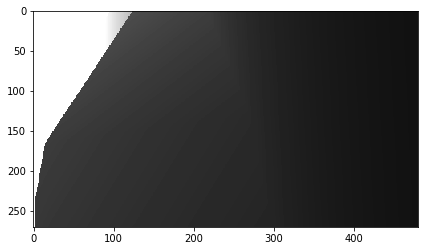

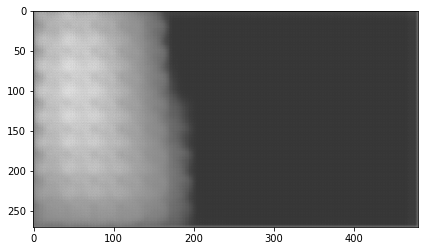

- After deconv 7, mean: 0.323 var: 3.516
- After sigmoid, mean: 0.511 var: 0.088
Epoch: 2/10, Step: 41/58, Avg loss: 7861.112, time: 186.21, Avg. per iter 4.51, Est. time left 76.60

- After deconv 7, mean: 0.269 var: 3.264
- After sigmoid, mean: 0.507 var: 0.086
Epoch: 2/10, Step: 42/58, Avg loss: 7798.426, time: 191.36, Avg. per iter 4.51, Est. time left 72.19

- After deconv 7, mean: -0.069 var: 2.139
- After sigmoid, mean: 0.461 var: 0.072
Epoch: 2/10, Step: 43/58, Avg loss: 7755.000, time: 195.86, Avg. per iter 4.51, Est. time left 67.68

- After deconv 7, mean: -0.232 var: 1.760
- After sigmoid, mean: 0.438 var: 0.070
Epoch: 2/10, Step: 44/58, Avg loss: 7684.551, time: 200.31, Avg. per iter 4.51, Est. time left 63.16

- After deconv 7, mean: -0.188 var: 1.494
- After sigmoid, mean: 0.455 var: 0.065
Epoch: 2/10, Step: 45/58, Avg loss: 7670.010, time: 204.54, Avg. per iter 4.51, Est. time left 58.61

- After deconv 7, mean: -0.058 var: 1.961
- After sigmoid, mean: 0.471 var: 0.073


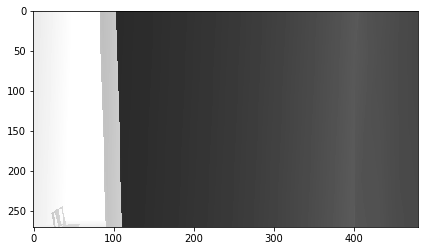

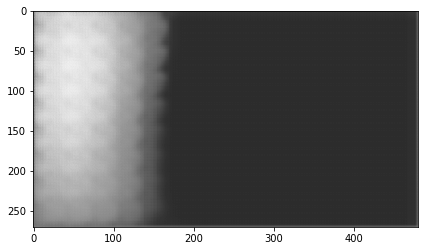

- After deconv 7, mean: -0.168 var: 2.125
- After sigmoid, mean: 0.450 var: 0.077
Epoch: 2/10, Step: 51/58, Avg loss: 7428.980, time: 230.19, Avg. per iter 4.50, Est. time left 31.47

- After deconv 7, mean: -0.071 var: 2.038
- After sigmoid, mean: 0.473 var: 0.075
Epoch: 2/10, Step: 52/58, Avg loss: 7381.233, time: 234.43, Avg. per iter 4.49, Est. time left 26.96

- After deconv 7, mean: -0.083 var: 2.206
- After sigmoid, mean: 0.470 var: 0.082
Epoch: 2/10, Step: 53/58, Avg loss: 7340.165, time: 238.72, Avg. per iter 4.49, Est. time left 22.46

- After deconv 7, mean: 0.039 var: 2.178
- After sigmoid, mean: 0.494 var: 0.079
Epoch: 2/10, Step: 54/58, Avg loss: 7290.664, time: 243.17, Avg. per iter 4.49, Est. time left 17.96

- After deconv 7, mean: 0.197 var: 2.182
- After sigmoid, mean: 0.524 var: 0.077
Epoch: 2/10, Step: 55/58, Avg loss: 7269.886, time: 247.27, Avg. per iter 4.49, Est. time left 13.46

- After deconv 7, mean: 0.080 var: 2.019
- After sigmoid, mean: 0.501 var: 0.071
E

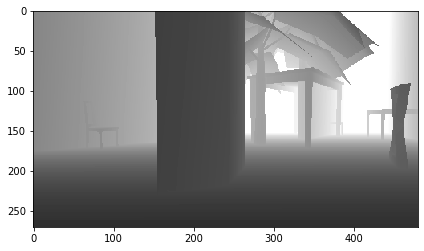

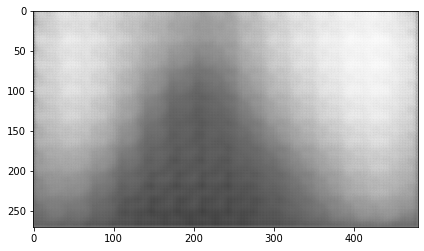

- After deconv 7, mean: 0.513 var: 3.043
- After sigmoid, mean: 0.551 var: 0.070
Epoch: 3/10, Step: 11/67, Avg loss: 5125.772, time: 48.90, Avg. per iter 4.46, Est. time left 249.99

- After deconv 7, mean: 0.309 var: 2.978
- After sigmoid, mean: 0.525 var: 0.084
Epoch: 3/10, Step: 12/67, Avg loss: 5123.566, time: 52.98, Avg. per iter 4.46, Est. time left 245.37

- After deconv 7, mean: 0.061 var: 2.424
- After sigmoid, mean: 0.494 var: 0.083
Epoch: 3/10, Step: 13/67, Avg loss: 5108.975, time: 57.15, Avg. per iter 4.46, Est. time left 240.79

- After deconv 7, mean: -0.223 var: 1.741
- After sigmoid, mean: 0.448 var: 0.069
Epoch: 3/10, Step: 14/67, Avg loss: 5175.863, time: 61.33, Avg. per iter 4.46, Est. time left 236.22

- After deconv 7, mean: -0.490 var: 1.481
- After sigmoid, mean: 0.395 var: 0.061
Epoch: 3/10, Step: 15/67, Avg loss: 5116.104, time: 65.61, Avg. per iter 4.46, Est. time left 231.70

- After deconv 7, mean: -0.501 var: 1.312
- After sigmoid, mean: 0.396 var: 0.056
E

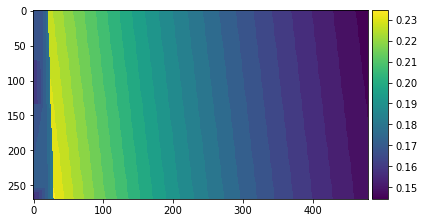

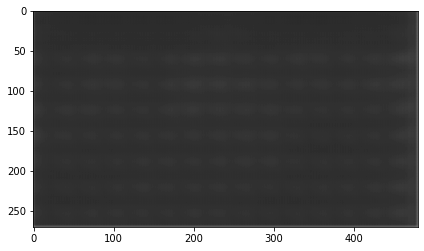

- After deconv 7, mean: 0.284 var: 2.588
- After sigmoid, mean: 0.524 var: 0.079
Epoch: 3/10, Step: 21/67, Avg loss: 5030.370, time: 92.87, Avg. per iter 4.46, Est. time left 205.06

- After deconv 7, mean: 0.498 var: 3.127
- After sigmoid, mean: 0.552 var: 0.085
Epoch: 3/10, Step: 22/67, Avg loss: 5023.949, time: 97.17, Avg. per iter 4.46, Est. time left 200.55

- After deconv 7, mean: 0.449 var: 2.686
- After sigmoid, mean: 0.552 var: 0.074
Epoch: 3/10, Step: 23/67, Avg loss: 5088.564, time: 101.36, Avg. per iter 4.45, Est. time left 196.01

- After deconv 7, mean: 0.125 var: 2.505
- After sigmoid, mean: 0.499 var: 0.081
Epoch: 3/10, Step: 24/67, Avg loss: 5097.721, time: 105.66, Avg. per iter 4.45, Est. time left 191.51

- After deconv 7, mean: -0.167 var: 1.769
- After sigmoid, mean: 0.456 var: 0.070
Epoch: 3/10, Step: 25/67, Avg loss: 5106.401, time: 110.08, Avg. per iter 4.45, Est. time left 187.05

- After deconv 7, mean: -0.324 var: 1.493
- After sigmoid, mean: 0.427 var: 0.061

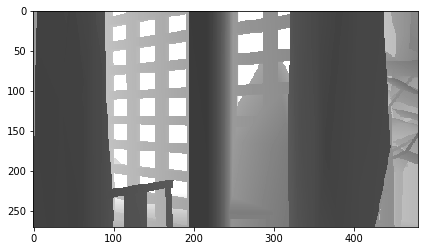

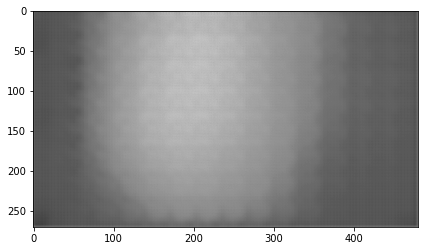

- After deconv 7, mean: -0.055 var: 2.099
- After sigmoid, mean: 0.473 var: 0.075
Epoch: 3/10, Step: 31/67, Avg loss: 4978.324, time: 135.69, Avg. per iter 4.45, Est. time left 160.02

- After deconv 7, mean: -0.092 var: 2.322
- After sigmoid, mean: 0.466 var: 0.080
Epoch: 3/10, Step: 32/67, Avg loss: 4966.233, time: 140.04, Avg. per iter 4.44, Est. time left 155.55

- After deconv 7, mean: -0.085 var: 2.795
- After sigmoid, mean: 0.466 var: 0.088
Epoch: 3/10, Step: 33/67, Avg loss: 4969.839, time: 144.42, Avg. per iter 4.44, Est. time left 151.09

- After deconv 7, mean: -0.281 var: 2.691
- After sigmoid, mean: 0.434 var: 0.087
Epoch: 3/10, Step: 34/67, Avg loss: 4961.611, time: 148.61, Avg. per iter 4.44, Est. time left 146.60

- After deconv 7, mean: -0.329 var: 2.647
- After sigmoid, mean: 0.432 var: 0.087
Epoch: 3/10, Step: 35/67, Avg loss: 4936.088, time: 152.85, Avg. per iter 4.44, Est. time left 142.11

- After deconv 7, mean: -0.268 var: 2.131
- After sigmoid, mean: 0.442 var:

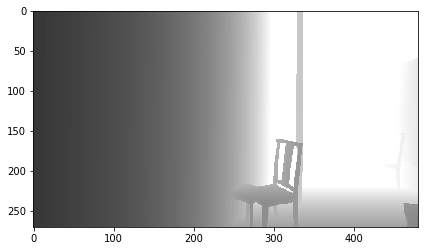

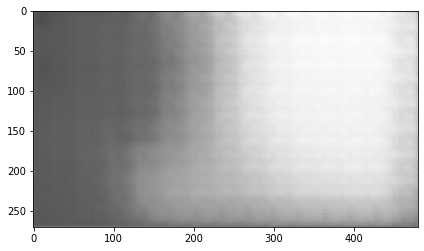

- After deconv 7, mean: 0.254 var: 1.762
- After sigmoid, mean: 0.531 var: 0.062
Epoch: 3/10, Step: 41/67, Avg loss: 4862.079, time: 178.67, Avg. per iter 4.43, Est. time left 115.30

- After deconv 7, mean: 0.226 var: 1.954
- After sigmoid, mean: 0.520 var: 0.065
Epoch: 3/10, Step: 42/67, Avg loss: 4859.509, time: 182.98, Avg. per iter 4.43, Est. time left 110.85

- After deconv 7, mean: 0.173 var: 2.455
- After sigmoid, mean: 0.508 var: 0.078
Epoch: 3/10, Step: 43/67, Avg loss: 4850.141, time: 187.18, Avg. per iter 4.43, Est. time left 106.38

- After deconv 7, mean: -0.110 var: 2.885
- After sigmoid, mean: 0.461 var: 0.088
Epoch: 3/10, Step: 44/67, Avg loss: 4810.436, time: 191.39, Avg. per iter 4.43, Est. time left 101.92

- After deconv 7, mean: -0.479 var: 3.076
- After sigmoid, mean: 0.413 var: 0.091
Epoch: 3/10, Step: 45/67, Avg loss: 4791.254, time: 195.71, Avg. per iter 4.43, Est. time left 97.47

- After deconv 7, mean: -0.596 var: 2.941
- After sigmoid, mean: 0.407 var: 0.0

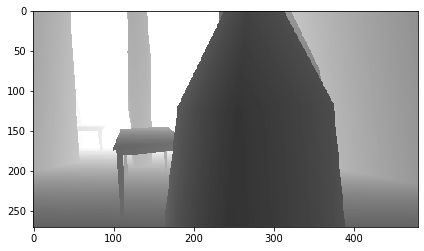

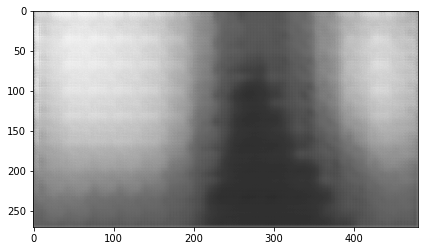

- After deconv 7, mean: 0.288 var: 2.311
- After sigmoid, mean: 0.528 var: 0.072
Epoch: 3/10, Step: 51/67, Avg loss: 4734.720, time: 222.79, Avg. per iter 4.43, Est. time left 70.92

- After deconv 7, mean: 0.408 var: 2.508
- After sigmoid, mean: 0.546 var: 0.075
Epoch: 3/10, Step: 52/67, Avg loss: 4721.542, time: 227.25, Avg. per iter 4.43, Est. time left 66.49

- After deconv 7, mean: 0.336 var: 2.434
- After sigmoid, mean: 0.530 var: 0.071
Epoch: 3/10, Step: 53/67, Avg loss: 4718.789, time: 231.71, Avg. per iter 4.43, Est. time left 62.05

- After deconv 7, mean: 0.164 var: 1.885
- After sigmoid, mean: 0.510 var: 0.064
Epoch: 3/10, Step: 54/67, Avg loss: 4701.318, time: 236.04, Avg. per iter 4.43, Est. time left 57.61

- After deconv 7, mean: -0.043 var: 1.576
- After sigmoid, mean: 0.477 var: 0.062
Epoch: 3/10, Step: 55/67, Avg loss: 4687.165, time: 240.45, Avg. per iter 4.43, Est. time left 53.18

- After deconv 7, mean: -0.119 var: 1.564
- After sigmoid, mean: 0.467 var: 0.065
Ep

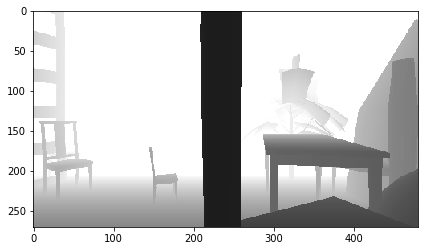

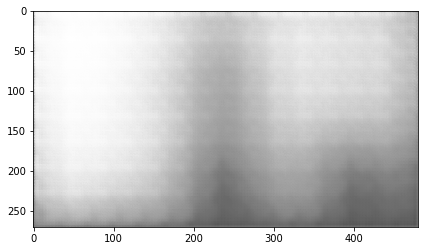

- After deconv 7, mean: 0.027 var: 4.080
- After sigmoid, mean: 0.468 var: 0.101
Epoch: 3/10, Step: 61/67, Avg loss: 4669.390, time: 267.14, Avg. per iter 4.43, Est. time left 26.58

- After deconv 7, mean: 0.102 var: 3.655
- After sigmoid, mean: 0.491 var: 0.103
Epoch: 3/10, Step: 62/67, Avg loss: 4664.788, time: 271.66, Avg. per iter 4.43, Est. time left 22.15

- After deconv 7, mean: -0.046 var: 3.710
- After sigmoid, mean: 0.462 var: 0.102
Epoch: 3/10, Step: 63/67, Avg loss: 4650.512, time: 275.85, Avg. per iter 4.43, Est. time left 17.72

- After deconv 7, mean: -0.143 var: 2.652
- After sigmoid, mean: 0.460 var: 0.085
Epoch: 3/10, Step: 64/67, Avg loss: 4643.722, time: 279.98, Avg. per iter 4.43, Est. time left 13.28

- After deconv 7, mean: -0.308 var: 2.074
- After sigmoid, mean: 0.428 var: 0.075
Epoch: 3/10, Step: 65/67, Avg loss: 4622.378, time: 284.26, Avg. per iter 4.43, Est. time left 8.85

- After deconv 7, mean: -0.324 var: 1.573
- After sigmoid, mean: 0.427 var: 0.065
E

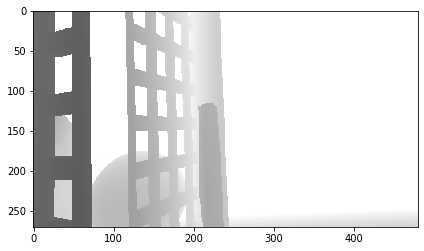

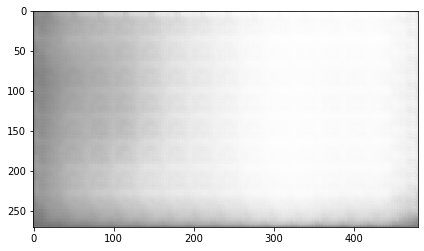

- After deconv 7, mean: -0.122 var: 2.516
- After sigmoid, mean: 0.462 var: 0.085
Epoch: 4/10, Step: 11/68, Avg loss: 3797.270, time: 49.95, Avg. per iter 4.43, Est. time left 252.31

- After deconv 7, mean: -0.385 var: 2.084
- After sigmoid, mean: 0.405 var: 0.067
Epoch: 4/10, Step: 12/68, Avg loss: 3737.101, time: 54.11, Avg. per iter 4.43, Est. time left 247.81

- After deconv 7, mean: -0.380 var: 1.687
- After sigmoid, mean: 0.412 var: 0.059
Epoch: 4/10, Step: 13/68, Avg loss: 3735.460, time: 58.21, Avg. per iter 4.42, Est. time left 243.30

- After deconv 7, mean: -0.337 var: 1.563
- After sigmoid, mean: 0.425 var: 0.059
Epoch: 4/10, Step: 14/68, Avg loss: 3741.699, time: 62.69, Avg. per iter 4.42, Est. time left 238.89

- After deconv 7, mean: -0.249 var: 1.820
- After sigmoid, mean: 0.442 var: 0.071
Epoch: 4/10, Step: 15/68, Avg loss: 3770.146, time: 67.19, Avg. per iter 4.42, Est. time left 234.48

- After deconv 7, mean: -0.149 var: 2.296
- After sigmoid, mean: 0.450 var: 0.07

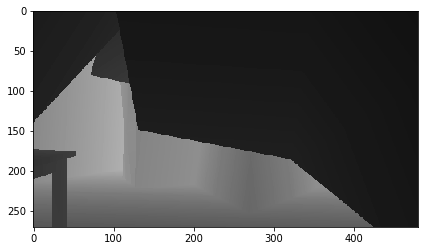

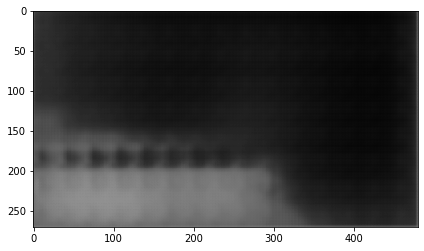

- After deconv 7, mean: -0.236 var: 3.411
- After sigmoid, mean: 0.436 var: 0.089
Epoch: 4/10, Step: 21/68, Avg loss: 3587.487, time: 93.65, Avg. per iter 4.42, Est. time left 207.88

- After deconv 7, mean: -0.374 var: 2.533
- After sigmoid, mean: 0.417 var: 0.079
Epoch: 4/10, Step: 22/68, Avg loss: 3568.052, time: 97.79, Avg. per iter 4.42, Est. time left 203.39

- After deconv 7, mean: -0.358 var: 1.908
- After sigmoid, mean: 0.421 var: 0.066
Epoch: 4/10, Step: 23/68, Avg loss: 3567.006, time: 102.12, Avg. per iter 4.42, Est. time left 198.95

- After deconv 7, mean: -0.317 var: 1.965
- After sigmoid, mean: 0.428 var: 0.072
Epoch: 4/10, Step: 24/68, Avg loss: 3558.330, time: 106.31, Avg. per iter 4.42, Est. time left 194.48

- After deconv 7, mean: -0.207 var: 1.552
- After sigmoid, mean: 0.441 var: 0.054
Epoch: 4/10, Step: 25/68, Avg loss: 3557.023, time: 110.43, Avg. per iter 4.42, Est. time left 190.00

- After deconv 7, mean: -0.106 var: 1.918
- After sigmoid, mean: 0.456 var: 0

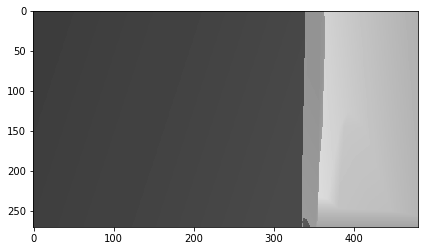

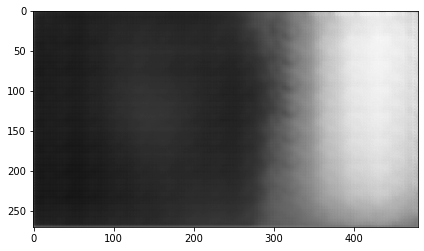

- After deconv 7, mean: -0.114 var: 2.566
- After sigmoid, mean: 0.459 var: 0.082
Epoch: 4/10, Step: 31/68, Avg loss: 3397.715, time: 135.60, Avg. per iter 4.41, Est. time left 163.23

- After deconv 7, mean: -0.073 var: 2.126
- After sigmoid, mean: 0.470 var: 0.071
Epoch: 4/10, Step: 32/68, Avg loss: 3373.168, time: 139.72, Avg. per iter 4.41, Est. time left 158.77

- After deconv 7, mean: -0.018 var: 1.913
- After sigmoid, mean: 0.480 var: 0.067
Epoch: 4/10, Step: 33/68, Avg loss: 3361.837, time: 143.83, Avg. per iter 4.41, Est. time left 154.32

- After deconv 7, mean: 0.057 var: 1.813
- After sigmoid, mean: 0.490 var: 0.062
Epoch: 4/10, Step: 34/68, Avg loss: 3356.448, time: 147.98, Avg. per iter 4.41, Est. time left 149.87

- After deconv 7, mean: 0.077 var: 1.832
- After sigmoid, mean: 0.486 var: 0.056
Epoch: 4/10, Step: 35/68, Avg loss: 3346.568, time: 152.11, Avg. per iter 4.41, Est. time left 145.42

- After deconv 7, mean: -0.010 var: 1.713
- After sigmoid, mean: 0.475 var: 0

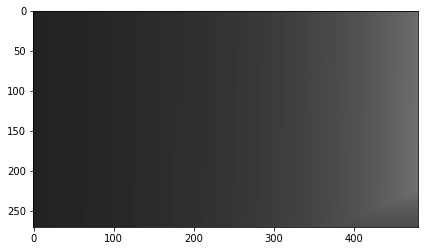

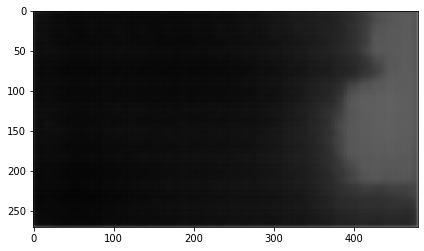

- After deconv 7, mean: -0.193 var: 4.109
- After sigmoid, mean: 0.451 var: 0.091
Epoch: 4/10, Step: 41/68, Avg loss: 3359.353, time: 178.83, Avg. per iter 4.41, Est. time left 118.99

- After deconv 7, mean: -0.037 var: 3.988
- After sigmoid, mean: 0.467 var: 0.096
Epoch: 4/10, Step: 42/68, Avg loss: 3351.622, time: 183.05, Avg. per iter 4.41, Est. time left 114.56

- After deconv 7, mean: -0.110 var: 3.417
- After sigmoid, mean: 0.445 var: 0.086
Epoch: 4/10, Step: 43/68, Avg loss: 3348.047, time: 187.23, Avg. per iter 4.41, Est. time left 110.13

- After deconv 7, mean: -0.242 var: 2.489
- After sigmoid, mean: 0.436 var: 0.079
Epoch: 4/10, Step: 44/68, Avg loss: 3317.769, time: 191.41, Avg. per iter 4.40, Est. time left 105.70

- After deconv 7, mean: -0.266 var: 1.758
- After sigmoid, mean: 0.441 var: 0.068
Epoch: 4/10, Step: 45/68, Avg loss: 3361.408, time: 195.52, Avg. per iter 4.40, Est. time left 101.27

- After deconv 7, mean: -0.246 var: 1.924
- After sigmoid, mean: 0.438 var:

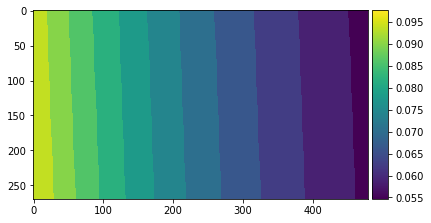

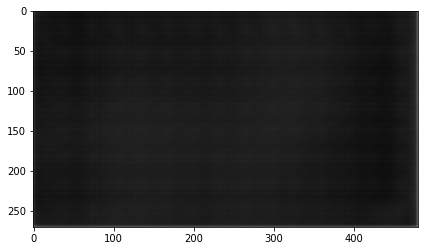

- After deconv 7, mean: -0.469 var: 2.729
- After sigmoid, mean: 0.396 var: 0.085
Epoch: 4/10, Step: 51/68, Avg loss: 3345.378, time: 220.48, Avg. per iter 4.40, Est. time left 74.73

- After deconv 7, mean: -0.490 var: 2.743
- After sigmoid, mean: 0.414 var: 0.091
Epoch: 4/10, Step: 52/68, Avg loss: 3351.543, time: 225.72, Avg. per iter 4.40, Est. time left 70.39

- After deconv 7, mean: -0.499 var: 2.586
- After sigmoid, mean: 0.394 var: 0.077
Epoch: 4/10, Step: 53/68, Avg loss: 3341.132, time: 230.53, Avg. per iter 4.40, Est. time left 66.02

- After deconv 7, mean: -0.432 var: 2.622
- After sigmoid, mean: 0.397 var: 0.078
Epoch: 4/10, Step: 54/68, Avg loss: 3329.900, time: 235.10, Avg. per iter 4.40, Est. time left 61.63

- After deconv 7, mean: -0.414 var: 2.433
- After sigmoid, mean: 0.408 var: 0.082
Epoch: 4/10, Step: 55/68, Avg loss: 3326.893, time: 239.70, Avg. per iter 4.40, Est. time left 57.23

- After deconv 7, mean: -0.438 var: 2.255
- After sigmoid, mean: 0.398 var: 0.07

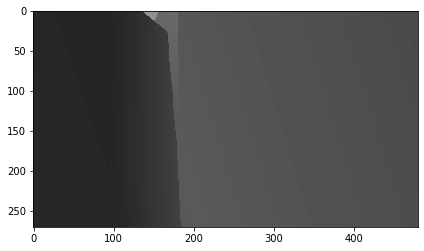

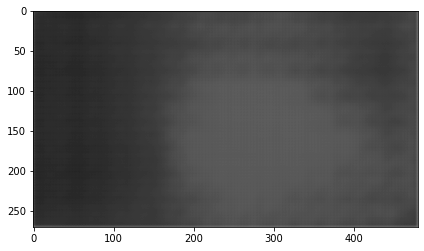

- After deconv 7, mean: 0.019 var: 2.273
- After sigmoid, mean: 0.483 var: 0.077
Epoch: 4/10, Step: 61/68, Avg loss: 3296.956, time: 266.47, Avg. per iter 4.40, Est. time left 30.82

- After deconv 7, mean: 0.076 var: 2.687
- After sigmoid, mean: 0.483 var: 0.081
Epoch: 4/10, Step: 62/68, Avg loss: 3294.597, time: 270.67, Avg. per iter 4.40, Est. time left 26.41

- After deconv 7, mean: 0.162 var: 2.967
- After sigmoid, mean: 0.490 var: 0.078


In [ ]:
time_iteration = []
# train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
# train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
# train_loader = next(iter(train_loader))

for epoch in range(num_epochs):
    overall_loss = 0
    overall_elbo = 0
    since = time.time()
    
    train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
    train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
    n_iterations = len(train_loader)
    
    for i, (image, *_) in enumerate(train_loader):
        since_iter = time.time()

        optimiser.zero_grad()

        # VAE forward pass
        x_hat, mu, logvar, z = vae_model(image)

        # Loss
        loss = mse_loss(image, x_hat, mu, logvar)

        overall_loss += loss

        # Update weights
        
        loss.backward()
        optimiser.step()
        
        
        time_iteration.append(time.time() - since_iter)
        iter_time_mean = np.array(time_iteration).mean()
        
        if (i+1) % 1 == 0:
            time_elapsed = time.time() - since
            print(f"Epoch: {epoch+1}/{num_epochs}, Step: {i+1}/{n_iterations}, Avg loss: {overall_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter {iter_time_mean:.2f}, Est. time left {iter_time_mean*(n_iterations - (i+1)):.2f}")
            print()
            
        if (i+1) % 10 == 0:
            imshow(image[0])
            imshow(x_hat[0].detach())
            

### Some results
- 10 epochs, no batch norm: 60191.195

In [ ]:
torch.save(vae_model.state_dict(), save_model_file)

In [ ]:
load_model=False
if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
    vae_model.eval()
else:
    vae_model.train()

# Training Run 2

In [ ]:
vae_model = VAE(n_z=latent_dim)

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
    vae_model.eval()
else:
    vae_model.train()

optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
summary(vae_model, (1, 270, 480))

In [ ]:
time_iteration = []
# train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
# train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
# train_loader = next(iter(train_loader))

for epoch in range(150):
    overall_loss = 0
    overall_elbo = 0
    since = time.time()
    
    train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
    train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
    n_iterations = len(train_loader)
    
    for i, (image, *_) in enumerate(train_loader):
        since_iter = time.time()

        optimiser.zero_grad()

        # VAE forward pass
        x_hat, mu, logvar, z = vae_model(image)

        # Loss
        loss = mse_loss(image, x_hat, mu, logvar)

        overall_loss += loss

        # Update weights
        
        loss.backward()
        optimiser.step()
        
        
        time_iteration.append(time.time() - since_iter)
        iter_time_mean = np.array(time_iteration).mean()
        
        if (i+1) % 5 == 0:
            time_elapsed = time.time() - since
            print(f"Epoch: {epoch+1}/{num_epochs}, Step: {i+1}/{n_iterations}, Avg loss: {overall_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter {iter_time_mean:.2f}, Est. time left {iter_time_mean*(n_iterations - (i+1)):.2f}")
            print()
            save_model_file = f"../../../vae_models/vae_resnet_drone_net_mse_{i+1}.pth"
            torch.save(vae_model.state_dict(), save_model_file)
            
        if (i+1) % 50 == 0:
            imshow(image[0])
            imshow(x_hat[0].detach())
            

# Evaluation

GOTCHA
- After deconv 7, mean: 0.225 var: 3.115
- After sigmoid, mean: 0.509 var: 0.083
tensor(0.5178) tensor(0.5095)
tensor(0.1111) tensor(0.0832)
torch.Size([32, 1, 270, 480])


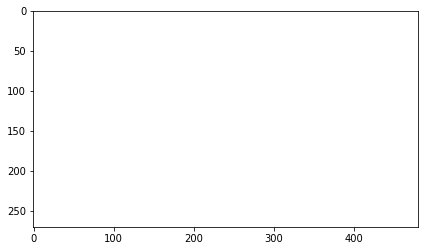

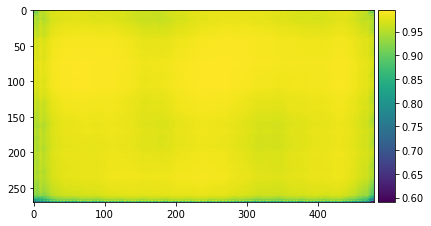

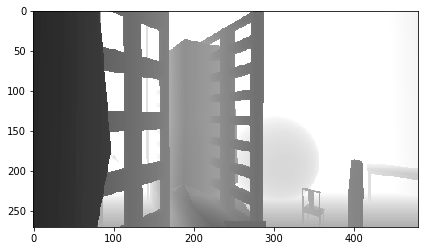

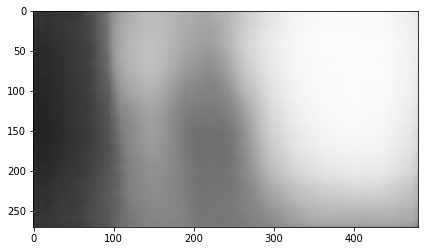

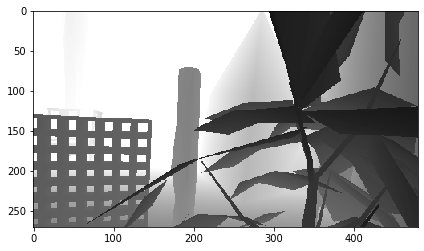

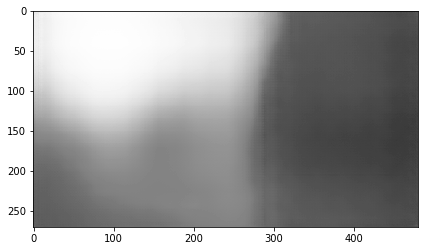

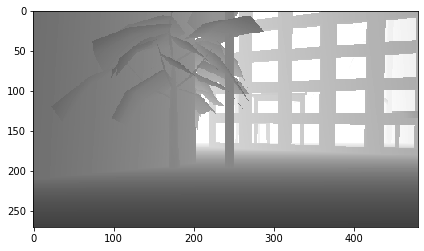

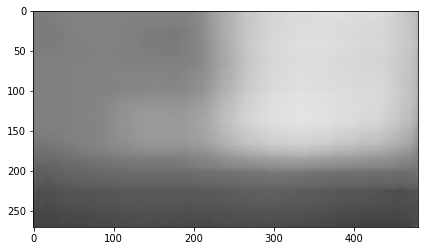

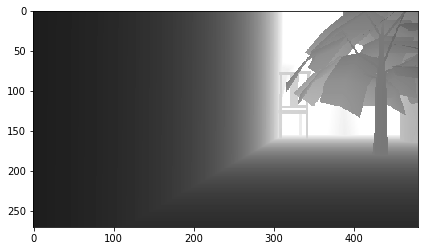

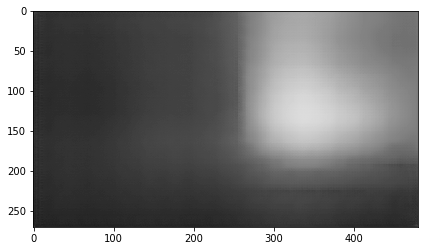

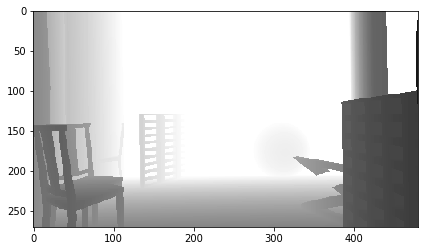

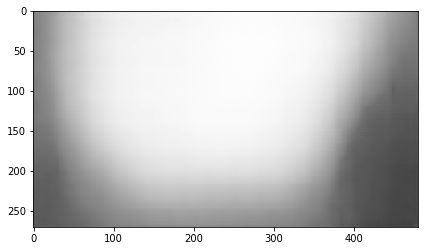

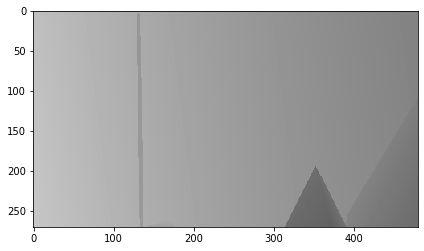

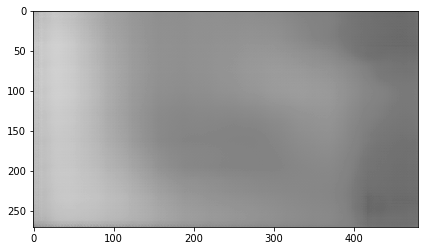

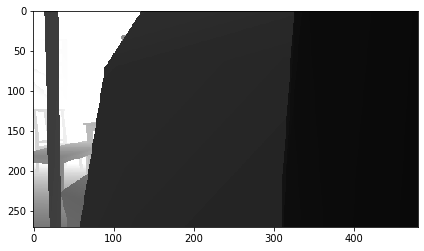

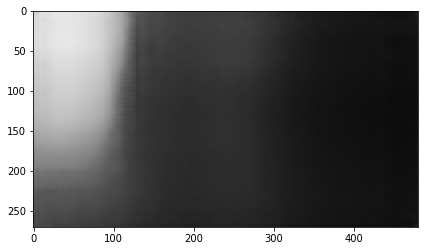

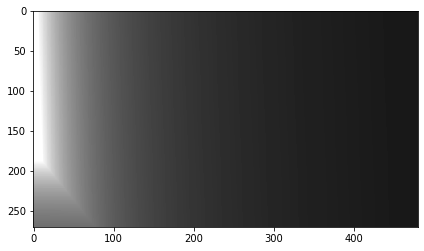

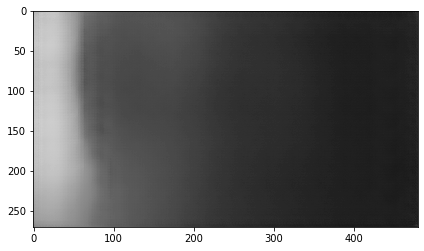

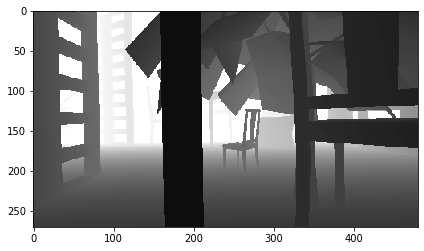

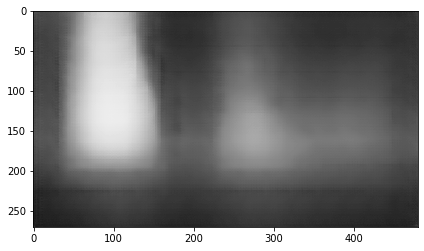

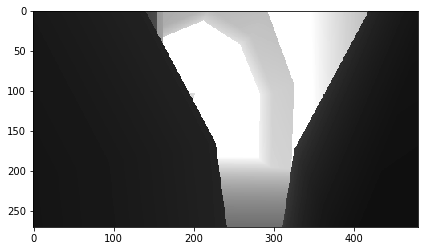

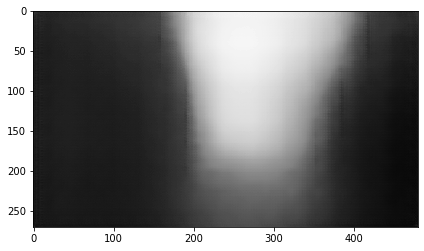

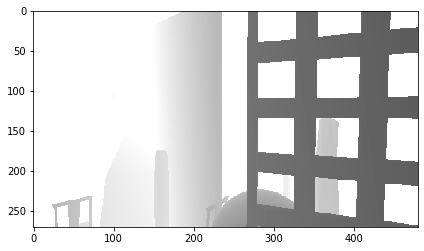

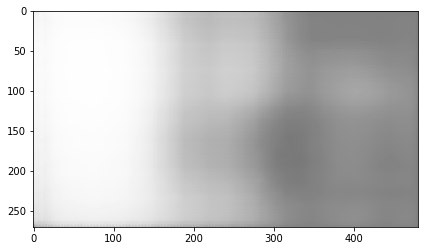

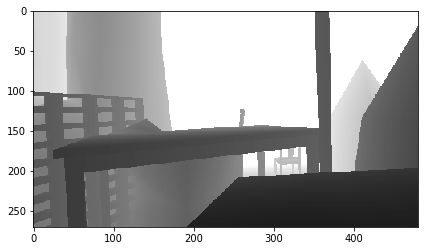

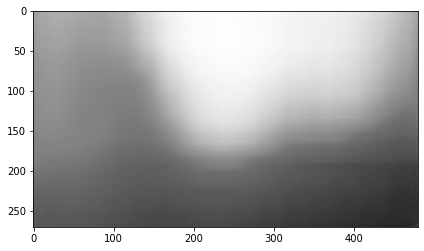

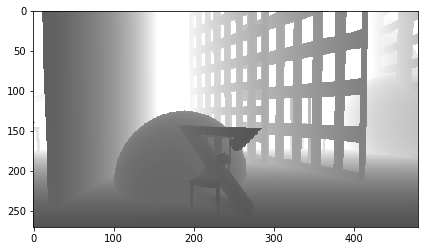

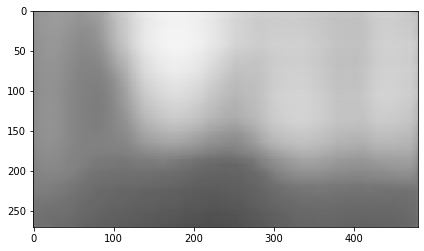

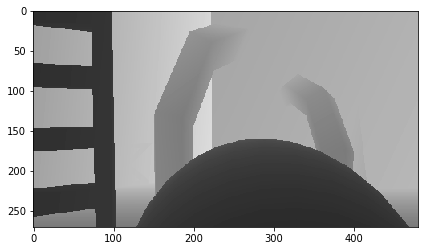

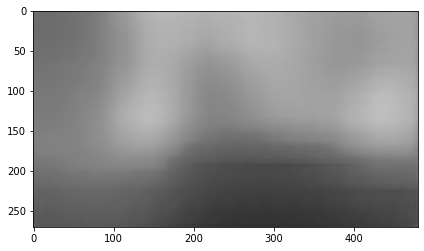

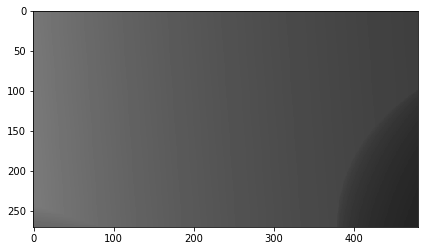

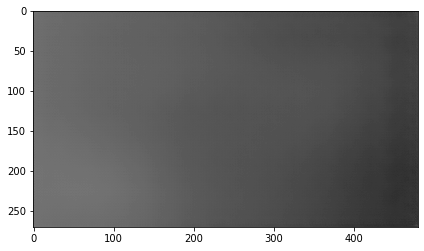

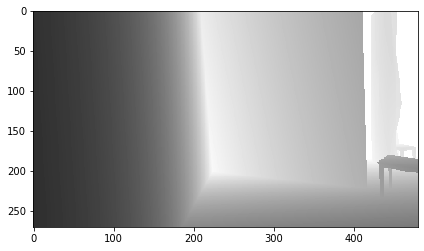

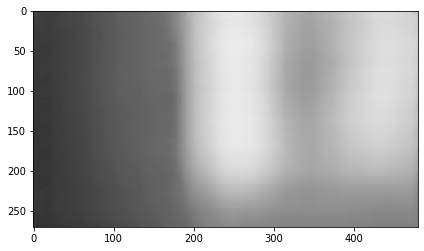

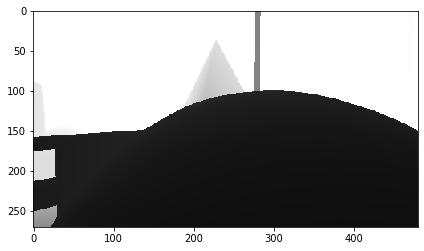

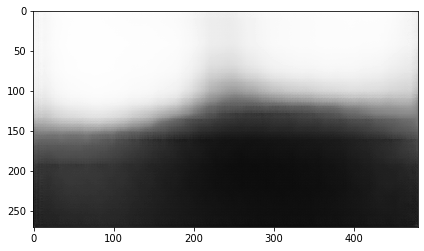

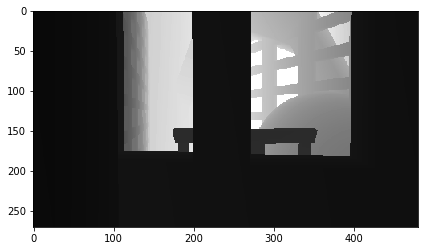

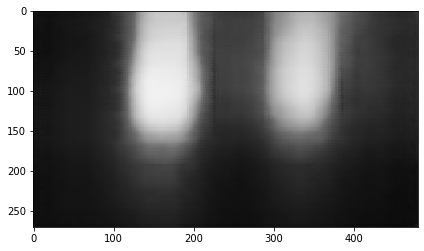

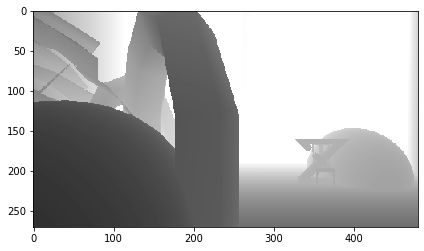

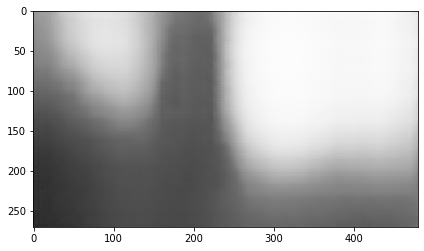

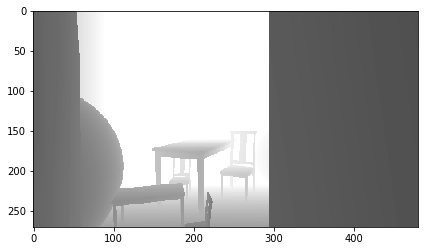

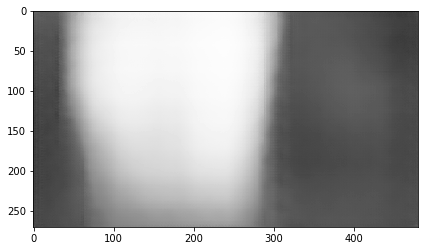

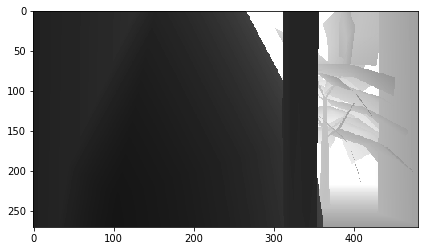

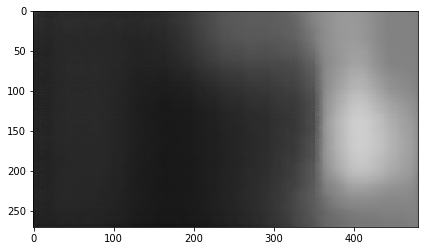

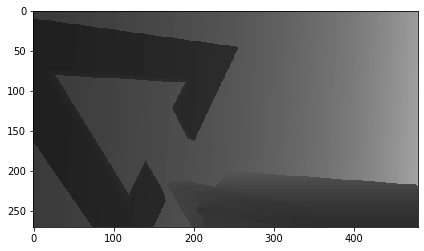

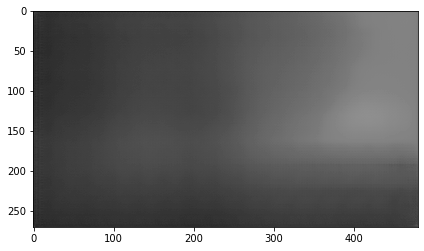

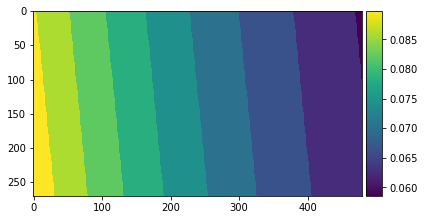

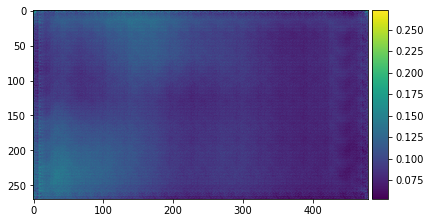

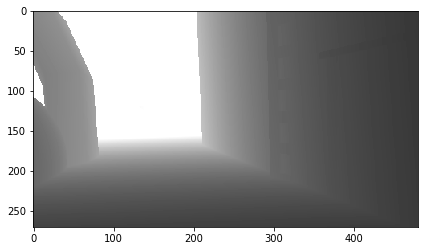

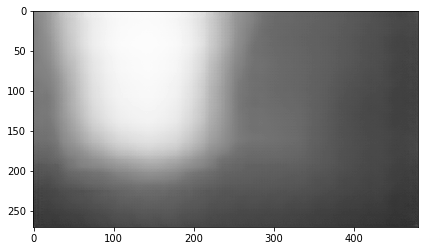

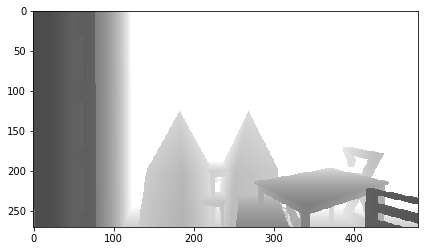

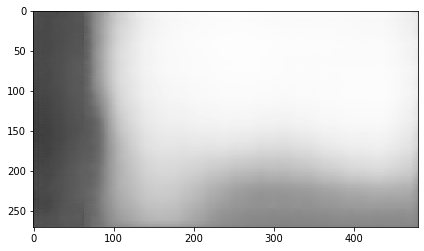

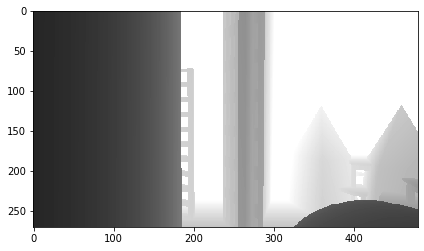

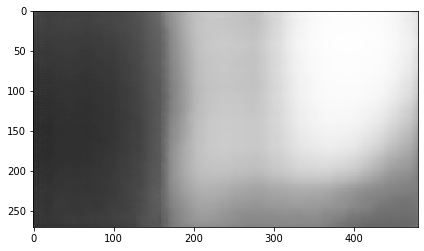

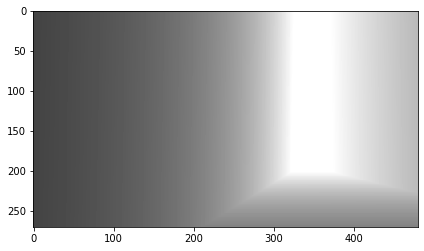

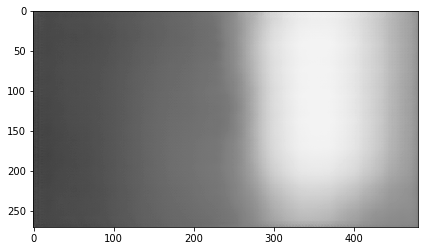

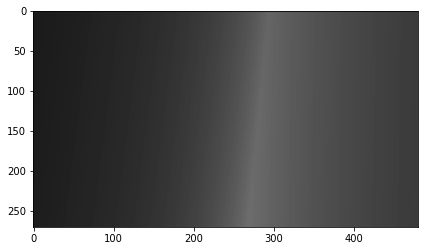

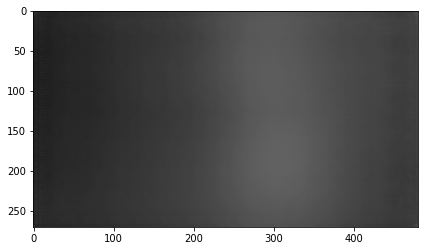

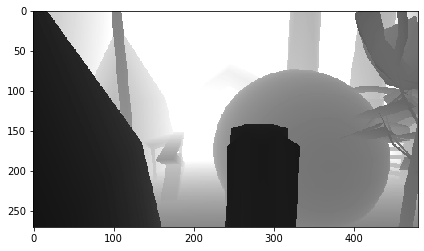

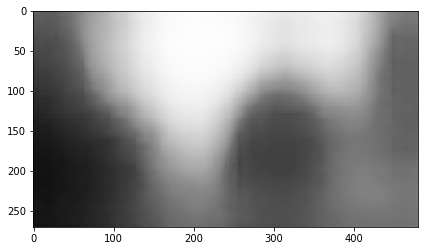

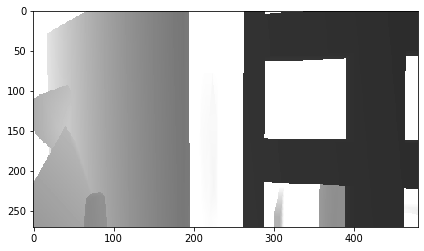

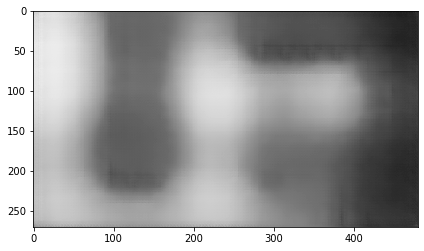

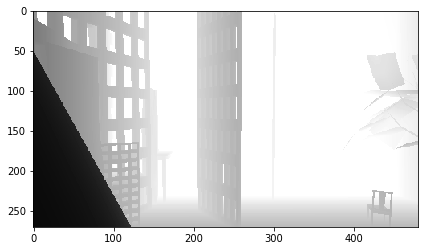

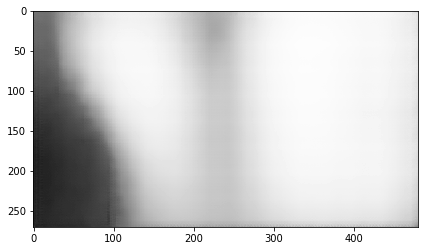

In [22]:
vae_model.eval()

# Visualise sample of images
with torch.no_grad():
    
    images, *_ = next(iter(test_loader))

    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), x_hat.mean())
    print(images.var(), x_hat.var())
    print(images.shape)
    for idx in range(len(images)):
        # show images
        imshow(images[idx])
        imshow(x_hat[idx])

Loading tfrecords...
['../../../rl_data/tfrecord/data132.tfrecords']
Iterating length...
Done.
GOTCHA
- Before deconv, mean: 0.005 var: 1.070
after deconv4 torch.Size([32, 32, 67, 120])
indices torch.Size([32, 32, 67, 120])
after unpool torch.Size([32, 32, 135, 240])
after deconv6 torch.Size([32, 16, 270, 480])
- After deconv 7, mean: 0.428 var: 4.346
- After sigmoid, mean: 0.518 var: 0.086
tensor(0.5148) tensor(0.5176)
tensor(0.1024) tensor(0.0858)
torch.Size([32, 1, 270, 480])


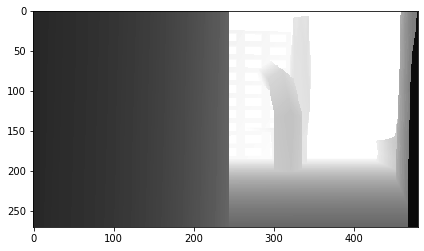

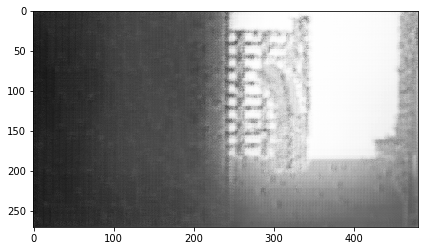

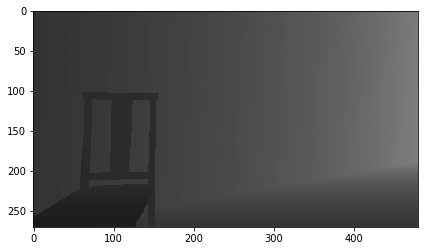

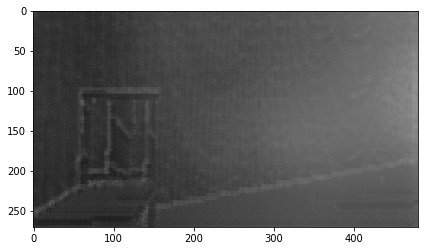

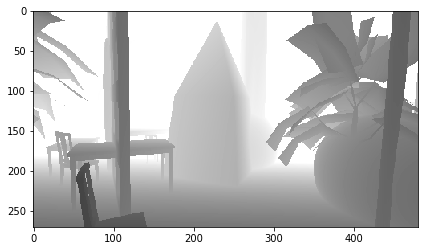

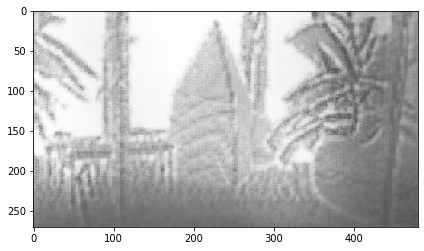

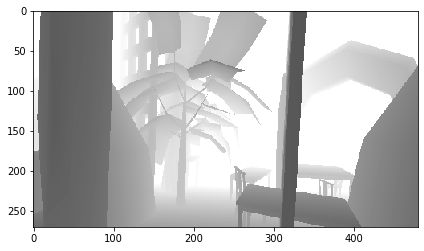

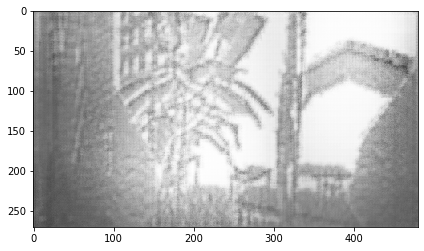

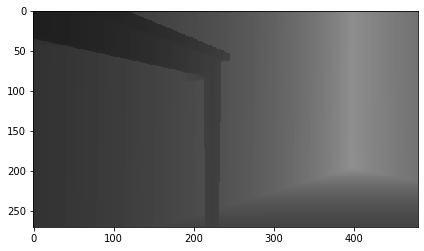

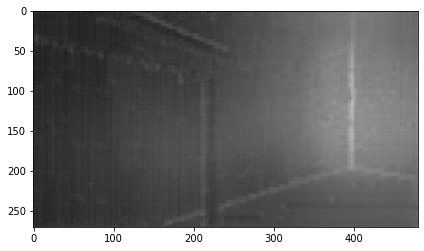

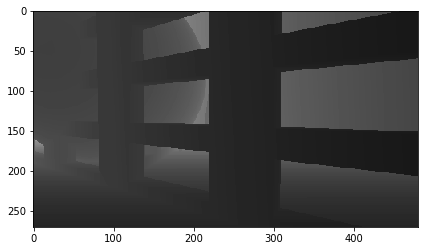

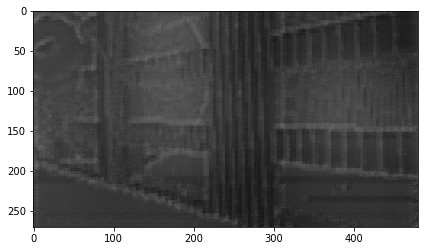

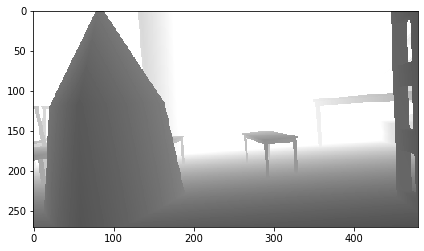

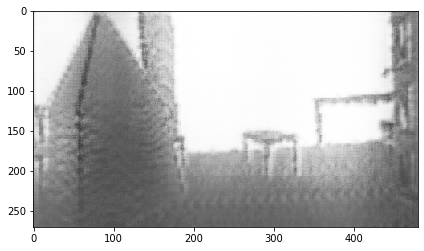

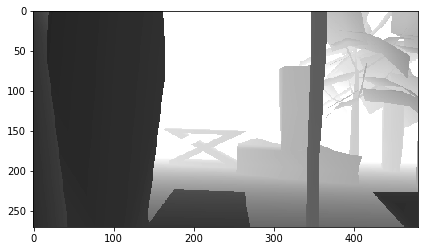

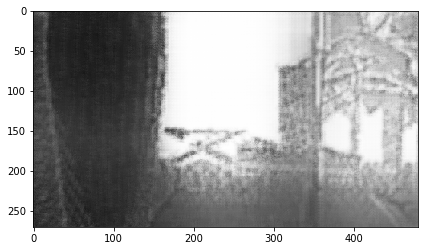

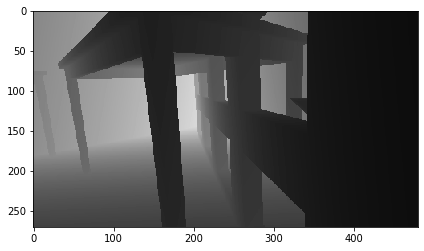

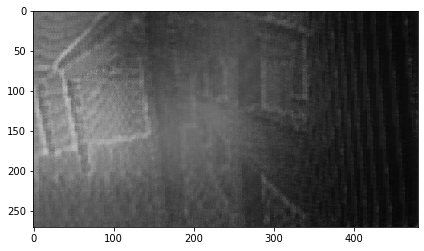

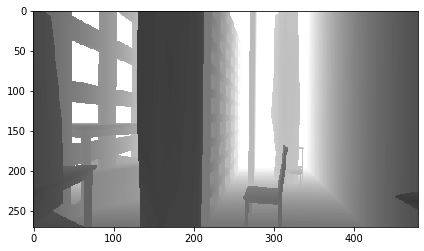

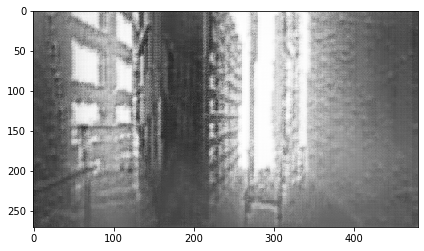

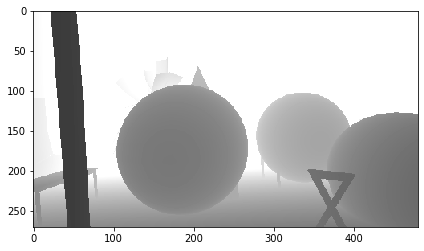

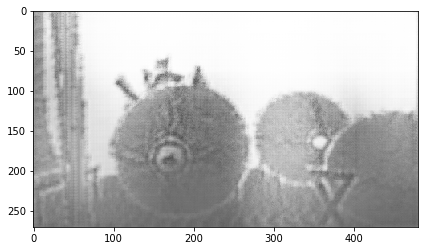

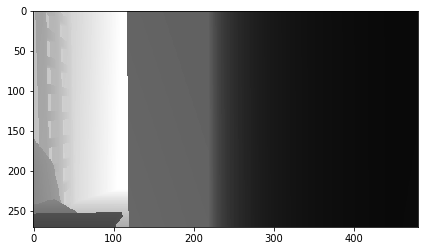

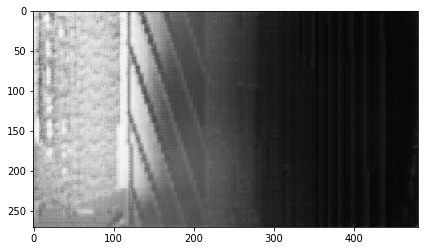

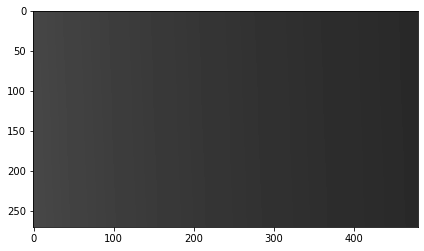

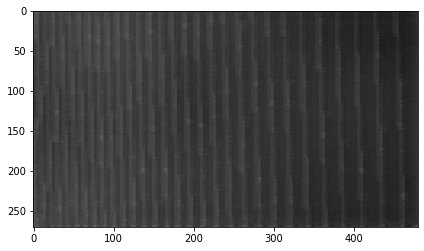

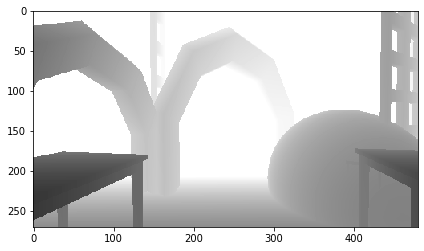

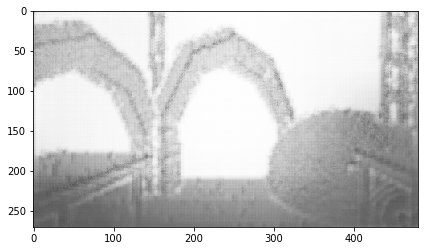

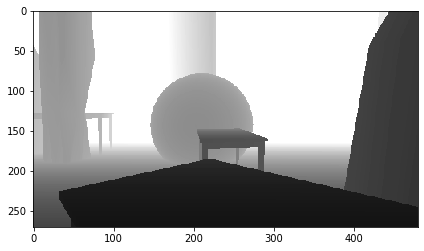

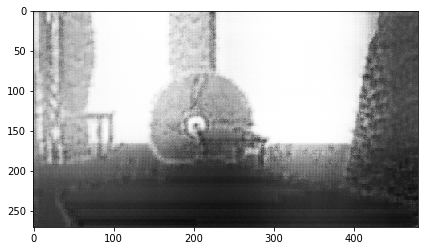

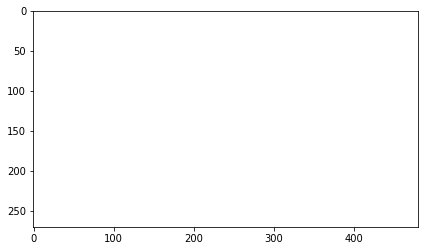

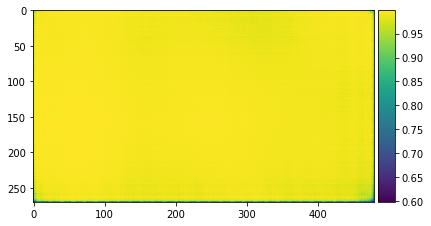

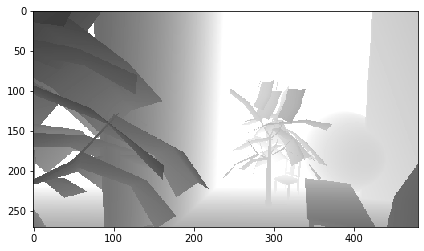

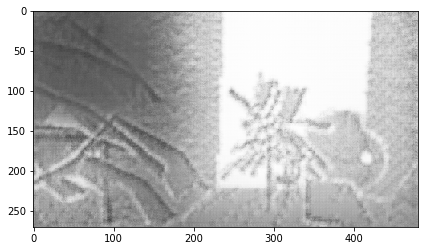

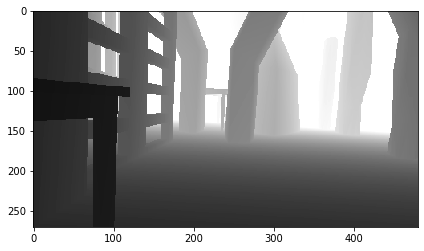

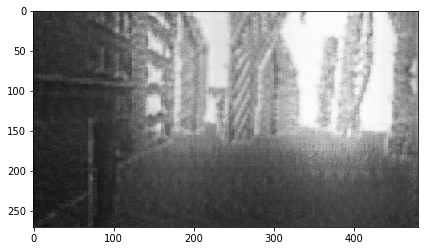

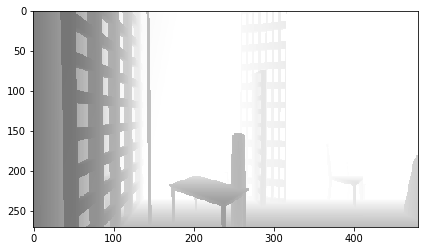

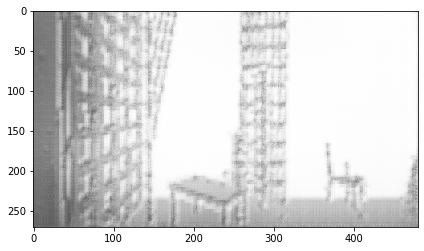

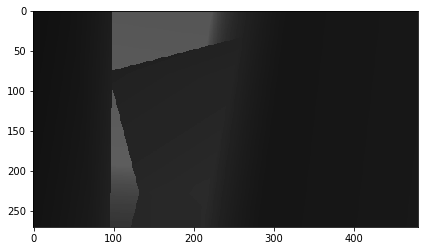

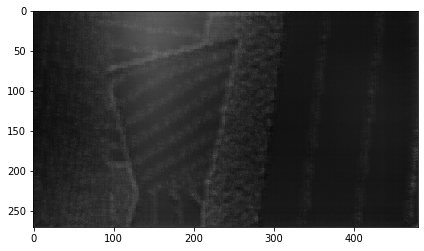

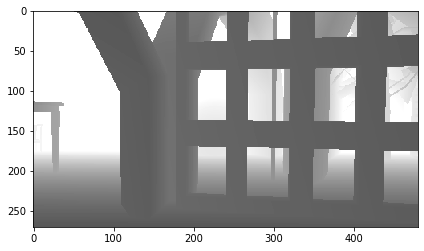

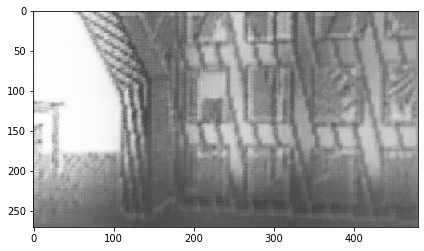

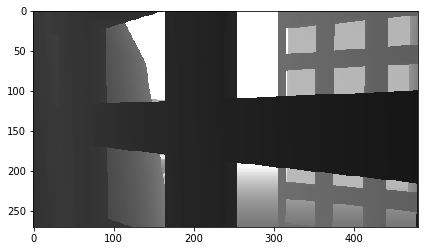

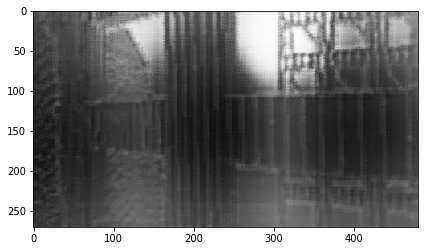

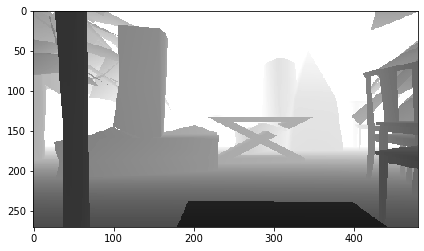

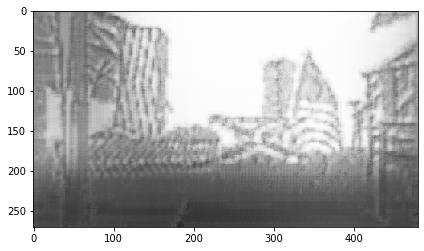

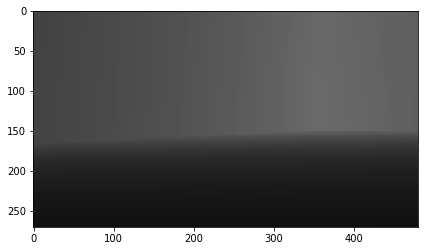

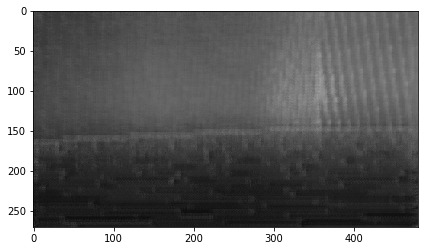

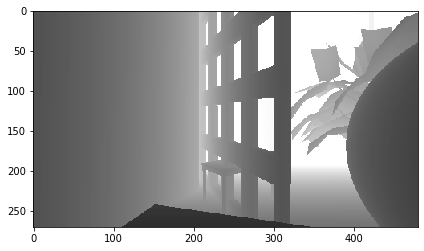

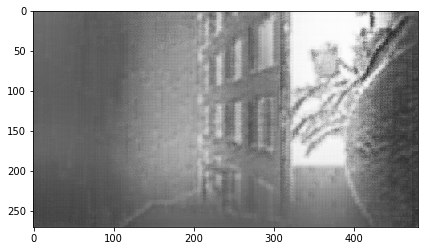

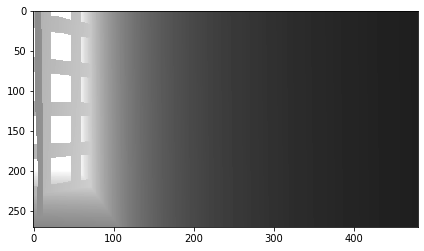

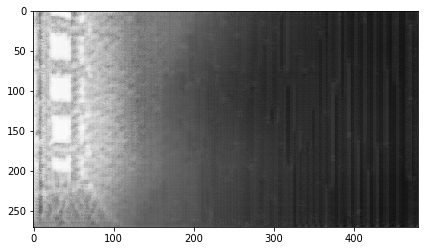

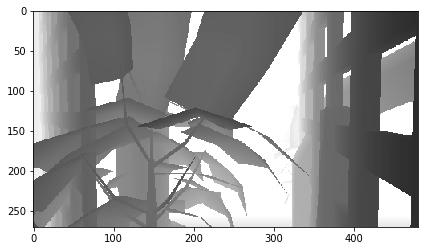

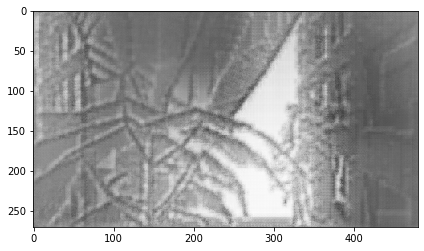

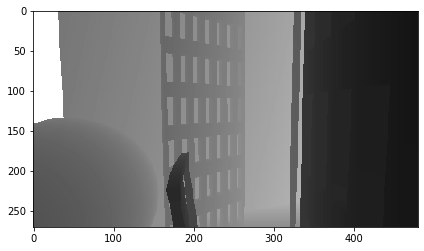

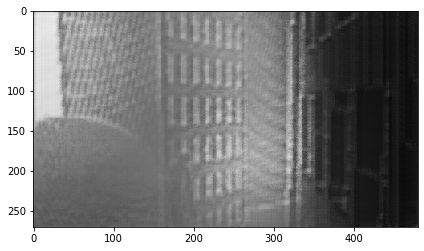

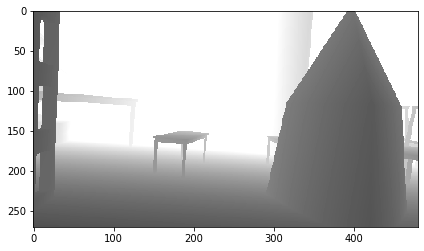

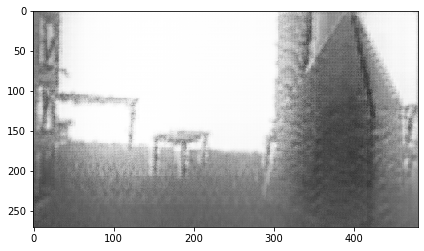

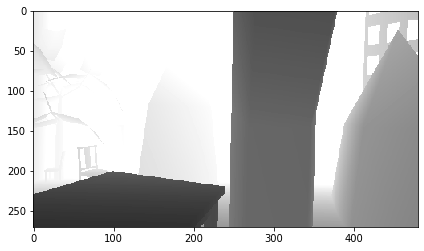

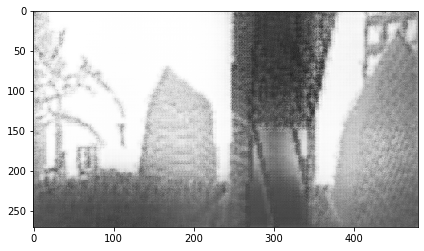

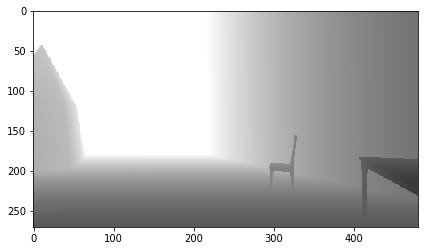

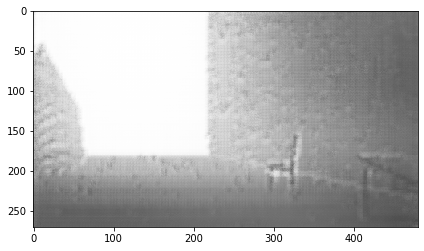

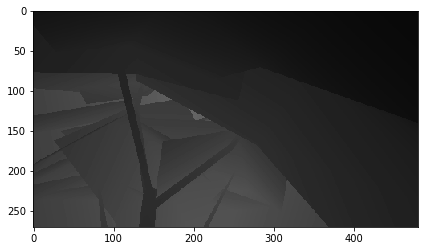

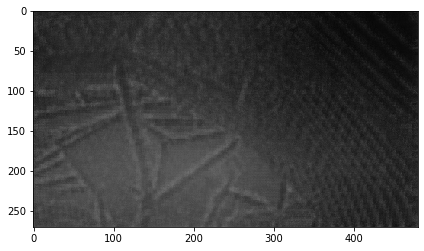

In [21]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)

vae_model.eval()
# Visualise sample of images

with torch.no_grad():
        
    images, *_ = next(iter(train_loader)) # if dataset is shuffled every iter(), essentially test 
    # VAE forward pass
    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), x_hat.mean())
    print(images.var(), x_hat.var())
    print(images.shape)
    for idx in range(len(images)):
        # show images
        imshow(images[idx])
        imshow(x_hat[idx])
